<a href="https://colab.research.google.com/github/abhilasha-kumar/modeling-lexical-retrieval/blob/main/LexicalRetrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Allow drive access

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# GPU access

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Found GPU at: /device:GPU:0
Sat Jan 15 19:45:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W /  70W |    264MiB / 15109MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                            

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import heapq
import itertools
import scipy.spatial.distance

import pandas as pd
import numpy as np

from numpy.random import randint
from scipy.special import softmax
from sklearn.preprocessing import MinMaxScaler, normalize
from numpy.linalg import matrix_power
from functools import lru_cache
import glob
from scipy.special import expit
from scipy import stats

import matplotlib.pyplot as plt
import nltk
from functools import lru_cache
from itertools import product as iterprod
import itertools
from nltk.metrics import *
import re

# Importing Data

In [5]:
with tf.device('/device:GPU:0'):
  julie_files = pd.read_csv("/content/drive/My Drive/LexicalRetrieval-2021/scripts data/Julie_2021data.csv", encoding= 'unicode_escape')
  vocab = pd.read_csv("/content/drive/My Drive/LexicalRetrieval-2021/scripts data/julie_vocab.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (23) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
len(julie_files)

17400

In [ ]:
(17400*11*2)+17400

400200

# Import USE

The Universal Sentence Encoder uses two different architctures to encode a string of any length into a compact high-dimensional vector representation -- the Deep Averaging Network (which is more of a bag-of-words approach) and the Transformer network (more predictive, attention-based). See link above for more details -- but DAN is generally faster and slightly less accurate than the Transformer model on NLP tasks (we might want to compare both). Below we see some examples of how we can use these "vectors" to find "closest neighbors"

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
dan_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
#transformer_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5" 
model = hub.load(dan_url)
print ("module %s loaded" % dan_url)

KeyboardInterrupt: ignored

In [ ]:
model(["Finland"])[0].shape

TensorShape([512])

In [ ]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [ ]:
sent1 = "Capital of Finland"
print("prompt is:", sent1)
sent1_vec = model([sent1])[0]
print("sent1_vec is a numpy array of shape:", sent1_vec.shape)
resp = list(vocab.vocab_word)
print(f"our vocab has {len(resp)} words from which we will find the ones closest to our sentence...")
cosine_list = [cosine(sent1_vec, model([r])[0]) for r in resp]
vocab["cosine"] = cosine_list
vocab.nlargest(10, "cosine")

prompt is: Capital of Finland
sent1_vec is a numpy array of shape: (512,)
our vocab has 12619 words from which we will find the ones closest to our sentence...


KeyboardInterrupt: ignored

In [ ]:
sent1 = "Last name of author of Little Women"
print("prompt is:", sent1)
sent1_vec = model([sent1])[0]
print("sent1_vec is a numpy array of shape:", sent1_vec.shape)
resp = list(vocab.vocab_word)
print(f"our vocab has {len(resp)} words from which we will find the ones closest to our sentence...")
cosine_list = [cosine(sent1_vec, model([r])[0]) for r in resp]
vocab["cosine"] = cosine_list
vocab.nlargest(10, "cosine")

prompt is: Last name of author of Little Women
sent1_vec is a numpy array of shape: (512,)
our vocab has 12619 words from which we will find the ones closest to our sentence...


,vocab_word,cosine
41,Alcott,0.387014
83,author,0.371520
11085,surname,0.349252
779,Rowling,0.270690
8518,petite,0.231320
780,runt,0.224465
7432,midget,0.220665
1944,biography,0.219154
12544,writer,0.217155
81,Austen,0.214192


In [ ]:
sent1 = "Instrument for performing calculations by sliding beads along rods or grooves"
print("prompt is:", sent1)
sent1_vec = model([sent1])[0]
print("sent1_vec is a numpy array of shape:", sent1_vec.shape)
resp = list(vocab.vocab_word)
print(f"our vocab has {len(resp)} words from which we will find the ones closest to our sentence...")
cosine_list = [cosine(sent1_vec, model([r])[0]) for r in resp]
vocab["cosine"] = cosine_list
vocab.nlargest(10, "cosine")

prompt is: Instrument for performing calculations by sliding beads along rods or grooves
sent1_vec is a numpy array of shape: (512,)
our vocab has 12619 words from which we will find the ones closest to our sentence...


,vocab_word,cosine
2,abacus,0.361816
148,calculations,0.336181
2405,calculation,0.305555
6389,instruments,0.305101
399,grooves,0.302247
12417,wind instrument,0.292259
104,beads,0.290021
6388,instrument,0.284906
471,Instrument,0.284906
7695,musical instrument,0.276964


The Transformer based USE model is pretty accurate in and of itself, whereas the DAN is not so accurate. But we want to model a "human" version of this model, so we can add some stochastic noise to these estimates for both models eventually

# Create phoneme function

Here we create a function that takes any letter string and partitions it into phonemes based on arpabet. Then we compute a measure of "normalized" phonemic similarity

In [ ]:
# algo to obtain phonemes for any given strng
# obtained from: https://stackoverflow.com/questions/33666557/get-phonemes-from-any-word-in-python-nltk-or-other-modules
try:
    arpabet = nltk.corpus.cmudict.dict()
except LookupError:
    nltk.download('cmudict')
    arpabet = nltk.corpus.cmudict.dict()

@lru_cache()
def wordbreak(s):
    s = s.lower()
    if s in arpabet:
        return arpabet[s]
    middle = len(s)/2
    partition = sorted(list(range(len(s))), key=lambda x: (x-middle)**2-x)
    for i in partition:
        pre, suf = (s[:i], s[i:])
        if pre in arpabet and wordbreak(suf) is not None:
            return [x+y for x,y in iterprod(arpabet[pre], wordbreak(suf))]
    return None

def normalized_sim(w1, w2):
  return 1-edit_distance(w1,w2)/(max(len(w1), len(w2)))

[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.


In [ ]:
w1 = "bird"
w2 = "burden"
print("wordbreak(w1)[0]:",wordbreak(w1)[0])
print("wordbreak(w2)[0]:",wordbreak(w2)[0])

print("normalized orthographic similarity (letters):", normalized_sim(w1, w2))
print("normalized phonemic similarity:", normalized_sim(wordbreak(w1)[0],wordbreak(w2)[0]))

wordbreak(w1)[0]: ['B', 'ER1', 'D']
wordbreak(w2)[0]: ['B', 'ER1', 'D', 'AH0', 'N']
normalized orthographic similarity (letters): 0.5
normalized phonemic similarity: 0.6


## semantic 

Below we get cosines from the prompt to the different primes and targets in our data

In [ ]:
## get cosines for:
# 1. prompt - target
# 2. prompt - primes
# 3. prompt - resp

both_prompt = []
neither_prompt = []
phon_prompt = []
sem_prompt = []
prime_prompt = []
target_prompt = []
resp_prompt = []

# 4. target- primes
target_both = []
target_neither = []
target_sem = []
target_phon = []
target_prime = []
# 5. target - answer
target_resp = []


for index, row in julie_files.iterrows():
  prompt_vec = model([row["prompt"]])[0]
  target_vec = model([row["Target"]])[0]
  resp = re.sub('[^a-zA-Z]+', '', str(row["Resp"]))
  prime = str(row["Prime"])
  #print("resp =", resp)
  

  both_prompt_sim = cosine(prompt_vec, model([row["Both"]])[0])
  both_prompt.append(both_prompt_sim)

  neither_prompt_sim = cosine(prompt_vec, model([row["Neither"]])[0])
  neither_prompt.append(neither_prompt_sim)

  phon_prompt_sim = cosine(prompt_vec, model([row["Phonological"]])[0])
  phon_prompt.append(phon_prompt_sim)

  sem_prompt_sim = cosine(prompt_vec, model([row["Semantic"]])[0])
  sem_prompt.append(sem_prompt_sim)

  prime_prompt_sim = cosine(prompt_vec, model([prime])[0])
  prime_prompt.append(prime_prompt_sim)

  target_prompt_sim = cosine(prompt_vec, model([row["Target"]])[0])
  target_prompt.append(target_prompt_sim)
  
  resp_prompt_sim = cosine(prompt_vec, model([resp])[0]) if resp != "" else "NA"
  resp_prompt.append(resp_prompt_sim)
  

  #4. target- primes
  target_both_sim = cosine(target_vec, model([row["Both"]])[0])
  target_both.append(target_both_sim)

  target_neither_sim = cosine(target_vec, model([row["Neither"]])[0])
  target_neither.append(target_neither_sim)

  target_sem_sim = cosine(target_vec, model([row["Semantic"]])[0])
  target_sem.append(target_sem_sim)

  target_phon_sim = cosine(target_vec, model([row["Phonological"]])[0])
  target_phon.append(target_phon_sim)

  target_prime_sim = cosine(target_vec, model([prime])[0])
  target_prime.append(target_prime_sim)

  # 5. target - answer
  target_resp_sim = cosine(target_vec, model([resp])[0]) if resp != "" else "NA"
  target_resp.append(target_resp_sim)


julie_files["both_prompt"]  = both_prompt
julie_files["neither_prompt"]  = neither_prompt
julie_files["sem_prompt"]  = sem_prompt
julie_files["phon_prompt"]  = phon_prompt

julie_files["prime_prompt"]  = prime_prompt
julie_files["target_prompt"]  = target_prompt
julie_files["resp_prompt"]  = resp_prompt

julie_files["target_both"]  = target_both
julie_files["target_neither"]  = target_neither
julie_files["target_sem"]  = target_sem
julie_files["target_phon"]  = target_phon
julie_files["target_prime"]  = target_prime
julie_files["target_resp"]  = target_resp





KeyboardInterrupt: ignored

## phon

Below we get estimates of phonemic similarity from the prompt to the different primes and targets in our data

In [ ]:
## get normalized phonemic similarities for:

# 4. target- primes
target_both = []
target_neither = []
target_sem = []
target_phon = []
target_prime = []
# 5. target - answer
target_resp = []


for index, row in julie_files.iterrows():
  
  resp = re.sub('[^a-zA-Z]+', '', str(row["Resp"]))
  semantic = re.sub('[^a-zA-Z]+', '', str(row["Semantic"]))
  phono = re.sub('[^a-zA-Z]+', '', str(row["Phonological"]))
  neither = re.sub('[^a-zA-Z]+', '', str(row["Neither"]))
  both = re.sub('[^a-zA-Z]+', '', str(row["Both"]))
  

  prime = re.sub('[^a-zA-Z]+', '', str(row["Prime"]))
  #print("resp =", resp)
  

  #4. target- primes
  target_both_sim = normalized_sim(wordbreak(row["Target"])[0],wordbreak(both)[0])
  target_both.append(target_both_sim)

  target_neither_sim = normalized_sim(wordbreak(row["Target"])[0],wordbreak(neither)[0])
  target_neither.append(target_neither_sim)

  target_sem_sim = normalized_sim(wordbreak(row["Target"])[0],wordbreak(semantic)[0])
  target_sem.append(target_sem_sim)

  target_phon_sim = normalized_sim(wordbreak(row["Target"])[0],wordbreak(phono)[0])
  target_phon.append(target_phon_sim)

  target_prime_sim = normalized_sim(wordbreak(row["Target"])[0],wordbreak(prime)[0])
  target_prime.append(target_prime_sim)

  # 5. target - answer
  target_resp_sim = normalized_sim(wordbreak(row["Target"])[0],wordbreak(resp)[0]) if resp != "" else "NA"
  target_resp.append(target_resp_sim)

julie_files["lev_target_both"]  = target_both
julie_files["lev_target_neither"]  = target_neither
julie_files["lev_target_sem"]  = target_sem
julie_files["lev_target_phon"]  = target_phon
julie_files["lev_target_prime"]  = target_prime
julie_files["lev_target_resp"]  = target_resp





In [ ]:
julie_files.to_csv("/content/drive/My Drive/LexicalRetrieval-2021/Julie_2021data.csv")

# Modeling Ideas

Some ways to think about how to "model" the task:


1. After obtaining the representation for the prompt and all words in the vocabulary, start an "activation" process such that at t = 0, activation "spreads" from the prompt to all words in proportion to their similarity to the prompt
2. At t=1, those words further spread activation to their neighbors.
3. This could continue for "t" time steps technically, but we can also introduce a prime at some time step. This "prime" gets some extra boost of activation (+5 units, say), and then similarities are assessed as a combination of prompt and cue to ultimately produce the response. 
4. Maybe the ideal way to do this is an "activation" matrix of size vocab x 1 for both semantic and phonology and then we merge the two eventually?
5. We may want to add in some stochastic noise to simulate partial knowledge in these models to see how that changes things
6. So a general process model might be:
*   activate_prompt_neighbors(noise) returns a 1-d array of similarities to every word in the vocab
*   activate_prime_neighbors(noise) returns two N-by-1 arrays of similarities+activation corresponding to semantic and phonological similarities
*   combine_semantic_phonological(method = "additive | multiplicative") returns a single N-by-1 array corresponding to combined sem-phon similarities after the promot and prime activations have been activated
*   generate_predictions() returns a softmax of the activated matrix
7. Ultimately, we want to make the code below efficient, and simulate about 100 participant runs with different levels of "noise" corresponding to levels of knowledge to obtain different model predictions
8. Also, we may want to have a parameter that controls the weight to semantic vs. phonological information in the "combine" function











## preparing/reducing data size

In [ ]:
## preparing data
julie_files["ActualPrime"] = np.where(julie_files['PrimeCondition'] == 'P', julie_files['Phonological'], 
                                      np.where(julie_files['PrimeCondition'] == 'B', julie_files['Both'], 
                                               np.where(julie_files['PrimeCondition'] == 'R', julie_files['Semantic'],julie_files['Neither']))) 
julie_files['prompt'] = julie_files['prompt'].str.replace('\t',' ')                                      
julie_files['prompt'] = julie_files['prompt'].str.strip()
print(f"full dataset is {len(julie_files)} rows")
## for target accuracy we only need 100 (prompts) x 4 (primes)
targetacc_data = julie_files[["ActualPrime", "PrimeCondition", "Target", "prompt"]].drop_duplicates()
for i in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]: 
  targetacc_data['AddPred' + str(i)] = np.nan
targetacc_data['MultPred'] = np.nan
print(f"target accuracy data is {len(targetacc_data)} rows")
## for response accuracy we need the unique responses for each prompt-prime combination

respacc_data = julie_files[["ActualPrime", "PrimeCondition", "Target", "Resp", "prompt"]].drop_duplicates()
print(f"response accuracy data is {len(respacc_data)} rows")

full dataset is 17400 rows
target accuracy data is 400 rows
response accuracy data is 4377 rows


In [ ]:
## we reshape the data so that we can run the functions at the "prompt" level
respacc_data = respacc_data.sort_values(by=['prompt'])
resp_wide = respacc_data.pivot(index = ["prompt", "Target", "Resp"], columns = ["PrimeCondition"], values = ["ActualPrime"])
resp_wide = resp_wide.reset_index()
resp_wide.columns = resp_wide.columns.map('|'.join).str.strip('|')
resp_wide = resp_wide[resp_wide.Resp != '12345']
resp_wide = resp_wide.reset_index()
for i in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]: 
  resp_wide['AddPred' + str(i)] = np.nan
resp_wide['MultPred'] = np.nan
resp_wide

,index,prompt,Target,Resp,ActualPrime|B,ActualPrime|P,ActualPrime|R,ActualPrime|U,AddPred0,AddPred0.1,AddPred0.2,AddPred0.3,AddPred0.4,AddPred0.5,AddPred0.6,AddPred0.7,AddPred0.8,AddPred0.9,AddPred1,MultPred
0,1,20th century American poet whose trademark was...,Cummings,Browning,NaN,NaN,Browning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,20th century American poet whose trademark was...,Cummings,Carrol,NaN,cummerbund,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,20th century American poet whose trademark was...,Cummings,Cummings,Cunningham,cummerbund,Browning,point,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,20th century American poet whose trademark was...,Cummings,Cunnigham,Cunningham,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,20th century American poet whose trademark was...,Cummings,Dickinson,Cunningham,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2665,2765,Word made by changing the order of letters in ...,anagram,palindrome,acronym,analytic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2666,2766,Word made by changing the order of letters in ...,anagram,plenumbra,acronym,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2667,2767,Word made by changing the order of letters in ...,anagram,puzzle,NaN,NaN,puzzle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2668,2768,Word made by changing the order of letters in ...,anagram,synonym,acronym,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Computing all vectors

In [ ]:
type(targetacc_data['AddPrediction'][0]) == float

True

In [ ]:
def vectors(data, vocab):
  prompts = pd.Series(data["prompt"].unique())
  p_vecs = np.array([model([x])[0].numpy() for x in prompts])
  print(p_vecs.shape)

  p_vectors_df = pd.DataFrame(p_vecs).transpose()
  print(p_vectors_df.shape)
  p_vectors_df.columns = prompts
  print(p_vectors_df.head())
  p_vectors_df.to_csv("/content/drive/My Drive/LexicalRetrieval-2021/PromptVectors_New.csv", index = False)

  words = list(vocab.vocab_word)
  w_vecs = np.array([model([x])[0].numpy() for x in words])
  print(w_vecs.shape)
  w_vectors_df = pd.DataFrame(w_vecs).transpose()

  print(w_vectors_df.shape)
  w_vectors_df.columns = words
  print(w_vectors_df.head())
  w_vectors_df.to_csv("/content/drive/My Drive/LexicalRetrieval-2021/VocabVectors_New.csv", index = False)

vectors(targetacc_data, vocab)


(100, 512)
(512, 100)
   To refrain deliberately and often with an effort of self-denial from an action or practice  ...  Happening by a lucky chance or by accident rather than by design
0                                           0.014262                                           ...                                          -0.002915               
1                                           0.018321                                           ...                                          -0.052756               
2                                           0.026393                                           ...                                          -0.002790               
3                                          -0.029389                                           ...                                           0.019612               
4                                           0.018353                                           ...                                           0.037026    

In [ ]:
prompt_vectors = pd.read_csv("/content/drive/My Drive/LexicalRetrieval-2021/PromptVectors_New.csv")
print(prompt_vectors.shape)
vocab_vectors = pd.read_csv("/content/drive/My Drive/LexicalRetrieval-2021/VocabVectors_New.csv")
print(vocab_vectors.shape)

(512, 100)
(512, 12619)


In [ ]:
prompt_vectors['Capital of South Korea']

0      0.018930
1     -0.011326
2      0.000773
3      0.041382
4     -0.006024
         ...   
507   -0.052603
508    0.031974
509   -0.059387
510   -0.077468
511   -0.072401
Name: Capital of South Korea, Length: 512, dtype: float64

In [ ]:
#type(prompt_vectors.loc[prompt_vectors['prompt'] == 'Capital of Finland']['vector'])
#type(vocab_vectors['vector'][1])
#type(model(['Finland'])[0].numpy())
#vocab_vectors.dtypes
cosine(prompt_vectors['Capital of Finland'].values, vocab_vectors['Finland'].values)


0.6351254414789951

## model functions

In [ ]:
def initial_activation(vocab_words):
  # returns an array of initial activations, currently zero, but eventually replace by word frequency
  x = np.zeros((len(vocab_words),1)).T
  return x

initial_activation(vocab).shape

(1, 12619)

In [ ]:
def activate_prompt_neighbors(activations, prompt, noise_level):
  ## takes in a 1-d array of current activations
  ## computes a vector representation of the prompt and returns a vector of similarities to each word in vocab + activations
  ## with some noise added to each estimate
  noise = np.random.normal(0, noise_level, 1)
  prompt_vec = prompt_vectors[prompt].values
  resp = vocab_vectors.columns
  cosine_list = np.array([cosine(prompt_vec, vocab_vectors[r].values) for r in resp]) + activations # eventually add noise
  return cosine_list

#x = activate_prompt_neighbors(initial_activation(vocab), "Capital of Finland", 0.1)

In [ ]:
def activate_prime_neighbors(prime):
  ## returns "primed" activations for both semantic and phonological 
  prime_vec = vocab_vectors[prime].values
  resp = vocab_vectors.columns
  semantic = np.array([cosine(prime_vec, vocab_vectors[r].values) for r in resp]) 
  phon = np.array([normalized_sim(r, prime) for r in resp]).reshape(semantic.shape)
  assert semantic.shape == phon.shape
  return semantic, phon

#y, z = activate_prime_neighbors('Oslo')

In [ ]:
def combine_semantic_phonological(prompt_act, semantic, phonological, theta=0): 
  # takes in activation arrays for prompt, prime-semantic, and prime phonological and combine with specified operation
  # returns softmax of combined activations
  if theta <= 1:
    wtds = theta * semantic
    wtdp = (1-theta)*phonological
    comb = np.add(wtds, wtdp) + prompt_act
  else:
    comb = np.multiply(semantic, phonological) + prompt_act
  return softmax(comb)

#combine_semantic_phonological(x, y, z, "add", 0.1)

In [ ]:
vocab_vectors.columns.get_loc('A')

0

In [ ]:
def generate_predictions(activations, vocab_words, topn = 10):
  ## takes in final activations and generates the top10 predictions
  return [list(vocab_words.vocab_word)[i] for i in np.argpartition(-activations, topn).flatten().tolist()[:topn]]

#generate_predictions(final_activations, vocab, topn = 10)

In [ ]:
def lexical_retrieval_model(prompt, prime, vocab_words, theta):
  ## brings all functions together
  init = initial_activation(vocab_words)
  x = activate_prompt_neighbors(init, vocab_words, prompt, 0.1)
  y, z = activate_prime_neighbors(x, vocab, prime)
  final_add = combine_semantic_phonological(y, z, "add", theta)
  final_mult = combine_semantic_phonological(y, z, "multiply")
  preds_add = generate_predictions(final_add, vocab_words, topn = 10)
  preds_mult = generate_predictions(final_mult, vocab_words, topn = 10)

  return preds_add, preds_mult

## to-do

1. now we should use the "wide" dataset above and run activate_prompt_neigbors only ONCE for each prompt 
2. so dont use the lexical_retrieval_model function but instead use the base functions (activate_prompt_neighbors etc.) by looping over the above dataset in a way that the prompt activation function is called only once and then you calculate the differnet prime activations for that same prompt activation array
3. Let's just do this for theta = 0.5 for now to see initial results 


# Response accuracy

In [ ]:
resp_wide

,index,prompt,Target,Resp,ActualPrime|B,ActualPrime|P,ActualPrime|R,ActualPrime|U,AddPred0,AddPred0.1,AddPred0.2,AddPred0.3,AddPred0.4,AddPred0.5,AddPred0.6,AddPred0.7,AddPred0.8,AddPred0.9,AddPred1,MultPred
0,1,20th century American poet whose trademark was...,Cummings,Browning,NaN,NaN,Browning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,20th century American poet whose trademark was...,Cummings,Carrol,NaN,cummerbund,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,20th century American poet whose trademark was...,Cummings,Cummings,Cunningham,cummerbund,Browning,point,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,20th century American poet whose trademark was...,Cummings,Cunnigham,Cunningham,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,20th century American poet whose trademark was...,Cummings,Dickinson,Cunningham,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2665,2765,Word made by changing the order of letters in ...,anagram,palindrome,acronym,analytic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2666,2766,Word made by changing the order of letters in ...,anagram,plenumbra,acronym,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2667,2767,Word made by changing the order of letters in ...,anagram,puzzle,NaN,NaN,puzzle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2668,2768,Word made by changing the order of letters in ...,anagram,synonym,acronym,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
r_acc = {'prompt': [],'PrimeCond': [], 'prime': [], 'Resp': [], 'theta': [], 'n': [], 'modelType': [],'RespAcc': []}
t_acc = {'prompt': [],'PrimeCond': [], 'prime': [], 'theta': [], 'n': [], 'modelType': [],'TargAcc': []}
prompt_acts = {}
prime_acts = {}
def accuracy_single(t, vocab_words, n, theta, pc):
  # adds 1 to corresponding list if the response/target is in the top n predictions, else 0
  #target accuracy
  global t_acc_df
  global r_acc_df
  if t < len(targetacc_data.index) and pc == targetacc_data["PrimeCondition"][t]: 
    if type(targetacc_data["AddPred"+str(theta)][t]) != list:
      if targetacc_data["prompt"][t] not in prompt_acts:
        init = initial_activation(vocab_words)
        prompt_neighbors = activate_prompt_neighbors(init, targetacc_data["prompt"][t], 0.1)
        prompt_acts[targetacc_data["prompt"][t]] = prompt_neighbors
      else:
        prompt_neighbors = prompt_acts[targetacc_data["prompt"][t]]

      if targetacc_data["ActualPrime"][t] not in prime_acts:
        a, b = activate_prime_neighbors(targetacc_data["ActualPrime"][t])
        prime_acts[targetacc_data["ActualPrime"][t]] = (a, b)
      else:
        a, b = prime_acts[targetacc_data["ActualPrime"][t]]
      final_add = combine_semantic_phonological(prompt_neighbors, a, b, "add", theta)
      targetacc_data["AddPred"+str(theta)][t] = generate_predictions(final_add, vocab_words, 20)
      if type(targetacc_data["MultPred"][t]) != list:
        final_mult = combine_semantic_phonological(prompt_neighbors, a, b, "multiply")
        targetacc_data["MultPred"][t] = generate_predictions(final_mult, vocab_words, 20)

    success = 1 if targetacc_data["Target"][t] in targetacc_data["AddPred"+str(theta)][t][:n] else 0
    t_acc["prompt"].append(targetacc_data["prompt"][t])
    t_acc["PrimeCond"].append(pc)
    t_acc["prime"].append(targetacc_data["ActualPrime"][t])
    t_acc["theta"].append(theta)
    t_acc["n"].append(n)
    t_acc["modelType"].append('add')
    t_acc["TargAcc"].append(success)
    success = 1 if targetacc_data["Target"][t] in targetacc_data["MultPred"][t][:n] else 0
    t_acc["prompt"].append(targetacc_data["prompt"][t])
    t_acc["PrimeCond"].append(pc)
    t_acc["prime"].append(targetacc_data["ActualPrime"][t])
    t_acc["theta"].append(theta)
    t_acc["n"].append(n)
    t_acc["modelType"].append('mult')
    t_acc["TargAcc"].append(success)

  #response accuracy
  col = "ActualPrime|" + pc
  if  pd.notna(resp_wide[col][t]):
    if type(resp_wide["AddPred" + str(theta)][t]) != list:
      if resp_wide["prompt"][t] not in prompt_acts:
        init = initial_activation(vocab_words)
        prompt_neighbors = activate_prompt_neighbors(init, resp_wide["prompt"][t], 0.1)
        prompt_acts[resp_wide["prompt"][t]] = prompt_neighbors
      else:
        prompt_neighbors = prompt_acts[resp_wide["prompt"][t]]
      
      if resp_wide[col][t] not in prime_acts:
        a, b = activate_prime_neighbors(resp_wide[col][t])
        prime_acts[resp_wide[col][t]] = (a, b)
      else:
        a, b = prime_acts[resp_wide[col][t]]
        
      final_add = combine_semantic_phonological(prompt_neighbors, a, b, "add", theta)
      resp_wide["AddPred"+str(theta)][t] = generate_predictions(final_add, vocab_words, 20)
      if type(resp_wide["MultPred"][t]) != list:
        final_mult = combine_semantic_phonological(prompt_neighbors, a, b, "multiply")
        resp_wide["MultPred"][t] = generate_predictions(final_mult, vocab_words, 20)

    success = 1 if resp_wide["Resp"][t].lower() in (pred.lower() for pred in resp_wide["AddPred"+str(theta)][t][:n]) else 0
    r_acc["prompt"].append(resp_wide["prompt"][t])
    r_acc["PrimeCond"].append(pc)
    r_acc["prime"].append(resp_wide[col][t])
    r_acc["Resp"].append(resp_wide["Resp"][t])
    r_acc["theta"].append(theta)
    r_acc["n"].append(n)
    r_acc["modelType"].append('add')
    r_acc["RespAcc"].append(success)
    success = 1 if resp_wide["Resp"][t].lower() in (pred.lower() for pred in resp_wide["MultPred"][t][:n]) else 0
    r_acc["prompt"].append(resp_wide["prompt"][t])
    r_acc["PrimeCond"].append(pc)
    r_acc["prime"].append(resp_wide[col][t])
    r_acc["Resp"].append(resp_wide["Resp"][t])
    r_acc["theta"].append(theta)
    r_acc["n"].append(n)
    r_acc["modelType"].append('mult')
    r_acc["RespAcc"].append(success)

def accuracy_overall(vocab_words, n, theta, pc):
  # returns the overall probability that the response will appear in the top n words predicted by the model
  for t in range(len(resp_wide.index)):
    accuracy_single(t, vocab_words, n, theta, pc)


In [ ]:
# create dataframe of response & target accuracies for all theta values, n 1-20, for each prime condition, 
# for additive and multiplicative model
theta = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
nums = range(1,21)
pc = ['B', 'P', 'R', 'U']
for p in pc:
  for a in theta:
    for n in nums:
      accuracy_overall(vocab, n, a, p)
    print("Completed with theta", a)

#r_acc_df.to_csv("/content/drive/My Drive/LexicalRetrieval-2021/ResponseAccuracy.csv", index = False)
#t_acc_df.to_csv("/content/drive/My Drive/LexicalRetrieval-2021/TargetAccuracy.csv", index = False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65:

Completed with theta 0
Completed with theta 0.1
Completed with theta 0.2
Completed with theta 0.3
Completed with theta 0.4
Completed with theta 0.5
Completed with theta 0.6
Completed with theta 0.7
Completed with theta 0.8
Completed with theta 0.9
Completed with theta 1
Completed with theta 0
Completed with theta 0.1
Completed with theta 0.2
Completed with theta 0.3
Completed with theta 0.4
Completed with theta 0.5
Completed with theta 0.6
Completed with theta 0.7
Completed with theta 0.8
Completed with theta 0.9
Completed with theta 1
Completed with theta 0
Completed with theta 0.1
Completed with theta 0.2
Completed with theta 0.3
Completed with theta 0.4
Completed with theta 0.5
Completed with theta 0.6
Completed with theta 0.7
Completed with theta 0.8
Completed with theta 0.9
Completed with theta 1
Completed with theta 0
Completed with theta 0.1
Completed with theta 0.2
Completed with theta 0.3
Completed with theta 0.4
Completed with theta 0.5
Completed with theta 0.6
Completed with

In [ ]:
r_acc_df = pd.DataFrame.from_dict(r_acc)
t_acc_df = pd.DataFrame.from_dict(t_acc)

In [ ]:
t_acc_df

,prompt,PrimeCond,prime,alpha,n,modelType,TargAcc
0,German city for which antisemitic laws were named,B,Norderstedt,0.0,1,add,0
1,German city for which antisemitic laws were named,B,Norderstedt,0.0,1,mult,0
2,"The escape of blood from vessels, including in...",B,hematoma,0.0,1,add,0
3,"The escape of blood from vessels, including in...",B,hematoma,0.0,1,mult,0
4,Having unlimited power; able to do anything,B,omniscient,0.0,1,add,0
...,...,...,...,...,...,...,...
175995,Last name of author of Little Women,U,truck,1.0,20,mult,0
175996,A small lizard with skin that changes color to...,U,bagel,1.0,20,add,1
175997,A small lizard with skin that changes color to...,U,bagel,1.0,20,mult,0
175998,Something out of keeping with the time in whic...,U,view,1.0,20,add,0


### grouping and plotting

In [ ]:
x = t_acc_df[['PrimeCond', 'TargAcc','theta', 'n']].groupby(['PrimeCond','theta', 'n']).mean()

TargAcc
PrimeCond alpha n          
B         0.0   1     0.035
                2     0.085
                3     0.100
                4     0.135
                5     0.165
...                     ...
U         1.0   16    0.105
                17    0.120
                18    0.135
                19    0.140
                20    0.150

[880 rows x 1 columns]

In [ ]:
r_acc_df.to_csv("/content/drive/My Drive/LexicalRetrieval-2021/ResponseAccuracy.csv", index = False)
t_acc_df.to_csv("/content/drive/My Drive/LexicalRetrieval-2021/TargetAccuracy.csv", index = False)

In [ ]:
#r_acc_df = pd.read_csv("/content/drive/My Drive/LexicalRetrieval-2021/ResponseAccuracy.csv")
#t_acc_df = pd.read_csv("/content/drive/My Drive/LexicalRetrieval-2021/TargetAccuracy.csv")
full_acc_df = pd.merge(r_acc_df, t_acc_df, how = 'left', on = ['prompt', 'PrimeCond', 'prime', 'theta', 'n', 'modelType'])
full_acc_df.rename(columns = {'PrimeCond': 'PrimeCondition'}, inplace = True)


In [ ]:
r_acc_df

,prompt,PrimeCond,prime,Resp,alpha,n,modelType,RespAcc
0,20th century American poet whose trademark was...,B,Cunningham,Cummings,0.0,1,add,0
1,20th century American poet whose trademark was...,B,Cunningham,Cummings,0.0,1,mult,0
2,20th century American poet whose trademark was...,B,Cunningham,Cunnigham,0.0,1,add,0
3,20th century American poet whose trademark was...,B,Cunningham,Cunnigham,0.0,1,mult,0
4,20th century American poet whose trademark was...,B,Cunningham,Dickinson,0.0,1,add,0
...,...,...,...,...,...,...,...,...
1749875,Word made by changing the order of letters in ...,U,chute,acrostic,1.0,20,mult,0
1749876,Word made by changing the order of letters in ...,U,chute,anagram,1.0,20,add,1
1749877,Word made by changing the order of letters in ...,U,chute,anagram,1.0,20,mult,1
1749878,Word made by changing the order of letters in ...,U,chute,palendrome,1.0,20,add,0


In [ ]:
prompt, primecondition, prime, resp

4875200

In [ ]:
# merge accuracy data with julie_files on prompt and PrimeCondition columns
julie_files = julie_files.merge(full_acc_df, how = 'outer', on = ['prompt', 'PrimeCondition', 'Resp'])

In [ ]:
julie_files

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,StudyNo,AgeGroup,PrimeInstruction,ExperimentName,Subject,Procedure,Trial,Both,Neither,Phonological,Semantic,Prime,PrimeCondition,Question.RESP,State.RT,FreeResp,Resp,FreeResp.RT,NewAccuracy,Accuracy,FreeRespPrimeIntrusion,Target,MCCorrect,McResp,McAcc,McRT,a,b,c,d,e,McActualResp,WhichPrime,ToEliminate,prompt,both_prompt,neither_prompt,sem_prompt,phon_prompt,prime_prompt,target_prompt,resp_prompt,target_both,target_neither,target_sem,target_phon,target_prime,target_resp,lev_target_both,lev_target_neither,lev_target_sem,lev_target_phon,lev_target_prime,lev_target_resp,ActualPrime,prime,alpha,n,modelType,RespAcc,TargAcc
0,0,0,0,6,Old,NotThePrime,tot not the prime,701,ExpProc1,1,avoid,dove,absolve,refuse,ABSOLVE,P,2,0,0,12345,1527,0,0,0,abstain,c,NaN,0,0,refuse,dove,abstain,absolve,avoid,0,X,0,To refrain deliberately and often with an effo...,0.066920,-0.033121,0.171530,0.127612,0.127612,0.125816,NaN,0.312840,0.089485,0.464569,0.217932,0.217932,NaN,0.166667,0.0,0.0,0.333333,0.333333,NaN,absolve,NaN,NaN,NaN,NaN,NaN,NaN
1,863,863,863,6,Old,NotThePrime,tot not the prime,709,ExpProc1,64,avoid,dove,absolve,refuse,ABSOLVE,P,2,1969,0,12345,123,0,0,0,abstain,c,c,1,3637,refuse,dove,abstain,absolve,avoid,abstain,0,0,To refrain deliberately and often with an effo...,0.066920,-0.033121,0.171530,0.127612,0.127612,0.125816,NaN,0.312840,0.089485,0.464569,0.217932,0.217932,NaN,0.166667,0.0,0.0,0.333333,0.333333,NaN,absolve,NaN,NaN,NaN,NaN,NaN,NaN
2,1954,1954,1954,6,Old,NotThePrime,tot not the prime,721,ExpProc1,55,avoid,dove,absolve,refuse,ABSOLVE,P,2,4106,0,12345,194,0,0,0,abstain,c,c,1,3690,refuse,dove,abstain,absolve,avoid,abstain,0,0,To refrain deliberately and often with an effo...,0.066920,-0.033121,0.171530,0.127612,0.127612,0.125816,NaN,0.312840,0.089485,0.464569,0.217932,0.217932,NaN,0.166667,0.0,0.0,0.333333,0.333333,NaN,absolve,NaN,NaN,NaN,NaN,NaN,NaN
3,3024,3024,3024,6,Old,NotThePrime,tot not the prime,733,ExpProc1,25,avoid,dove,absolve,refuse,ABSOLVE,P,2,9819,0,12345,288,0,0,0,abstain,c,e,0,8729,refuse,dove,abstain,absolve,avoid,avoid,B,0,To refrain deliberately and often with an effo...,0.066920,-0.033121,0.171530,0.127612,0.127612,0.125816,NaN,0.312840,0.089485,0.464569,0.217932,0.217932,NaN,0.166667,0.0,0.0,0.333333,0.333333,NaN,absolve,NaN,NaN,NaN,NaN,NaN,NaN
4,3886,3886,3886,5,Young,NotThePrime,tot not the prime,169,ExpProc1,87,avoid,dove,absolve,refuse,ABSOLVE,P,4,3203,NaN,12345,462,0,0,0,abstain,e,e,1,2517,dove,avoid,absolve,refuse,abstain,abstain,0,0,To refrain deliberately and often with an effo...,0.066920,-0.033121,0.171530,0.127612,0.127612,0.125816,NaN,0.312840,0.089485,0.464569,0.217932,0.217932,NaN,0.166667,0.0,0.0,0.333333,0.333333,NaN,absolve,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4347252,17397,17397,17397,1,Young,NoInstruction,tot 48 ms,44,ExpProc4,98,Wilson,ball,wattage,Doyle,Wilson,B,1,5276,{SHIFT}Wagner{SPACE},Wagner,2528,0,0,NaN,Watson,a,a,1,3346,Watson,wattage,Doyle,Wilson,ball,Watson,0,0,Last name of Sherlock Holmes' assistant and fr...,0.158221,0.101450,0.342255,-0.037300,0.158221,0.350901,0.116549,0.406117,0.331885,0.525539,0.148385,0.406117,0.27318,0.666667,0.0,0.0,0.666667,0.666667,0.166667,Wilson,Wilson,1.0,18.0,mult,0.0,1.0
4347253,17397,17397,17397,1,Young,NoInstruction,tot 48 ms,44,ExpProc4,98,Wilson,ball,wattage,Doyle,Wilson,B,1,5276,{SHIFT}Wagner{SPACE},Wagner,2528,0,0,NaN,Watson,a,a,1,3346,Watson,wattage,Doyle,Wilson,ball,Watson,0,0,Last name of Sherlock Holmes' assistant and fr...,0.158221,0.101450,0.342255,-0.037300,0.158221,0.350901,0.116549,0.406117,0.331885,0.525539,0.148385,0.406117,0.27318,0.666667,0.0,0.0,0.666667,0.666667,0.166667,Wilson,Wilson,1.0,19.0,add,0.0,1.0
4347254,17397,17397,17397,1,Young,NoInstructio

In [ ]:
len(julie_files)

4347257

In [ ]:
julie_files.to_csv("/content/drive/My Drive/LexicalRetrieval-2021/Julie_2021data_merged.csv")

In [ ]:
both = julie_files.loc[julie_files['PrimeCondition']=='B', ['theta', 'n', 'modelType', 'RespAcc', 'TargAcc']]
phonological = julie_files.loc[julie_files['PrimeCondition']=='P', ['theta', 'n', 'modelType', 'RespAcc', 'TargAcc']]
semantic = julie_files.loc[julie_files['PrimeCondition']=='R', ['theta', 'n', 'modelType', 'RespAcc', 'TargAcc']]
neither = julie_files.loc[julie_files['PrimeCondition']=='U', ['theta', 'n', 'modelType', 'RespAcc', 'TargAcc']]

In [ ]:
merged_julie_files = pd.read_csv("/content/drive/My Drive/LexicalRetrieval-2021/Julie_2021data_merged.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (25,37) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
x = julie_files[['PrimeCondition', 'theta', 'n','TargAcc', 'RespAcc', 'modelType']].groupby(['PrimeCondition','theta', 'n', 'modelType']).mean()

In [ ]:
x.loc[('B', slice(None) , [1.0, 5.0, 10.0], 'add'), 'TargAcc'].idxmax()


('B', 0.6, 10.0, 'add')

In [ ]:
old_julie = pd.read_csv("/content/drive/My Drive/LexicalRetrieval-2021/Julie_2021data.csv", encoding= 'unicode_escape')
participant_acc = old_julie[["PrimeCondition", "NewAccuracy"]].groupby(["PrimeCondition"]).mean() 
participant_acc


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (23) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,NewAccuracy
PrimeCondition,
B,0.247126
P,0.314253
R,0.217241
U,0.213333


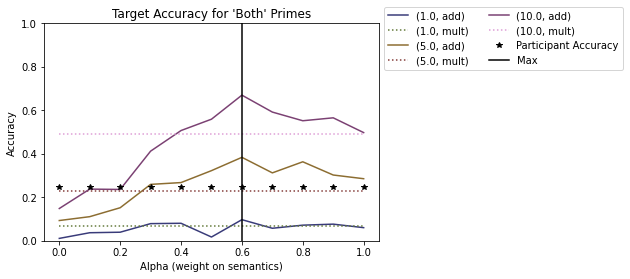

In [ ]:
#test unstack plotting
theta = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
both = x.loc['B']
styles = ['-', ':'] * 20
both.loc[(slice(None), [1.0, 5.0, 10.0]),'TargAcc'].unstack([-2, -1]).plot(ylim=(0,1),style = styles, colormap = 'tab20b', xlabel= "theta (weight on semantics)", ylabel = "Accuracy", title = "Target Accuracy for 'Both' Primes")
plt.plot(theta, [participant_acc.loc['B']]*11, 'k*', label="Participant Accuracy")
plt.axvline(x=x.loc[('B', slice(None) , [1.0, 5.0, 10.0], 'add'), 'TargAcc'].idxmax()[1], label="Max", color = "k")
plt.legend(bbox_to_anchor=(1.0, 1.1), ncol=2)
plt.show()

## Most up-to-date plots

In [ ]:
# plots
pc = ['B', 'P', 'R', 'U']
theta = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

def make_plots():
  for p in pc:
    cond = ""
    if p == 'B':
      cond = "Both"
    elif p == 'P':
      cond = "Phonological"
    elif p == 'R':
      cond = "Semantic"
    else:
      cond = "Neither"
    sub = x.loc[p]
    styles = ['-', ':'] * 20
    sub.loc[(slice(None), [1.0, 5.0, 10.0]),'TargAcc'].unstack([-2, -1]).plot(style = styles, colormap = 'tab20b', ylim=(0,1), xlabel= "theta (weight on semantics)", ylabel = "Accuracy", title = "Target Accuracy for " + cond + " Primes")
    plt.plot(theta, [participant_acc.loc[p]]*11, 'k*', label="Participant Accuracy")
    plt.axvline(x=x.loc[(p, slice(None) , [1.0, 5.0, 10.0], 'add'), 'TargAcc'].idxmax()[1], label="Max", color = "k")
    plt.legend()
    plt.show()

    sub.loc[(slice(None), [1.0, 5.0, 10.0]),'RespAcc'].unstack([-2, -1]).plot(style = styles, colormap = 'tab20b', ylim=(0,1), xlabel= "theta (weight on semantics)", ylabel = "Accuracy", title = "Response Accuracy for " + cond + " Primes")
    plt.axvline(x=x.loc[(p, slice(None) , [1.0, 5.0, 10.0], 'add'), 'RespAcc'].idxmax()[1], label="Max", color = "k")
    plt.legend()
    plt.show()

    

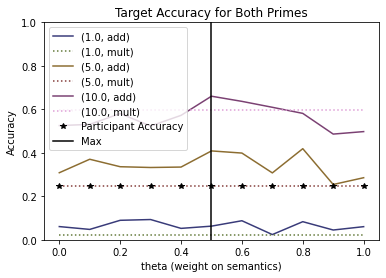

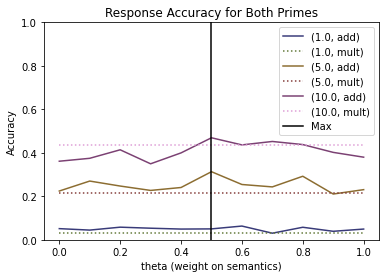

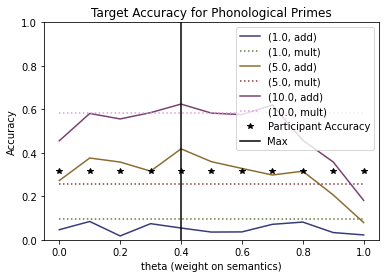

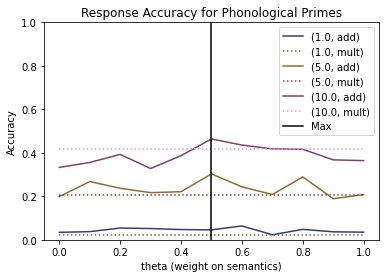

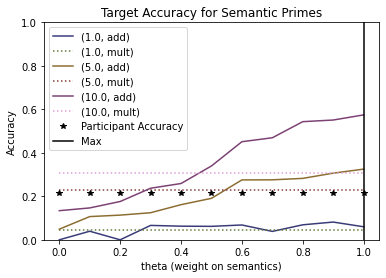

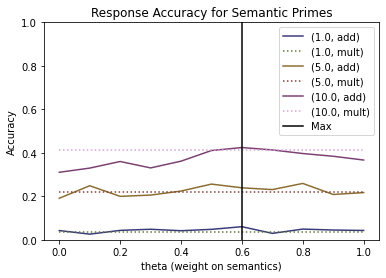

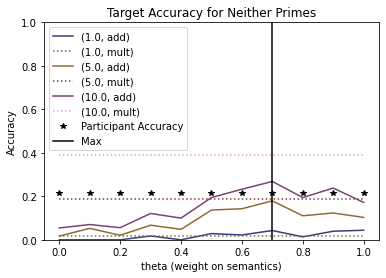

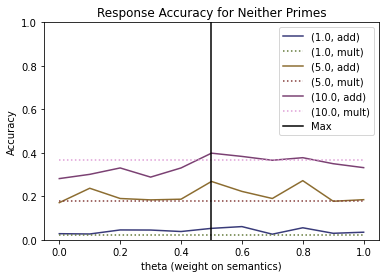

In [ ]:
make_plots()

## RT vs. activation

In [ ]:
type(julie_files['Resp'][0])

str

In [ ]:
rtdf = {'Resp': [],  'theta': [], 'prime': [], 'PrimeCondition': [], 'RT': [], 'modelType':[], 'FinalRespAct': []}
prompt_acts = {}
prime_acts = {}
theta = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
julie_files['ActualPrime'] = np.where(julie_files['PrimeCondition'] == 'P', julie_files['Phonological'], 
                                      np.where(julie_files['PrimeCondition'] == 'B', julie_files['Both'], 
                                               np.where(julie_files['PrimeCondition'] == 'R', julie_files['Semantic'],julie_files['Neither']))) 
julie_files['prompt'] = julie_files['prompt'].str.replace('\t',' ')                                      
julie_files['prompt'] = julie_files['prompt'].str.strip()
for index, row in julie_files.iterrows():
  for x in theta:
    if row['Resp'] != '12345' and row['Resp'] in vocab_vectors.columns:

      if row["prompt"] not in prompt_acts:
        init = initial_activation(vocab)
        prompt_neighbors = activate_prompt_neighbors(init, row["prompt"], 0.1)
        prompt_acts[row["prompt"]] = prompt_neighbors
      else:
        prompt_neighbors = prompt_acts[row["prompt"]]

      if row["ActualPrime"] not in prime_acts:
        a, b = activate_prime_neighbors(row["ActualPrime"])
        prime_acts[row["ActualPrime"]] = (a, b)
      else:
        a, b = prime_acts[row["ActualPrime"]]
      final_add = combine_semantic_phonological(prompt_neighbors, a, b, "add", x)
      final_mult = combine_semantic_phonological(prompt_neighbors, a, b, "multiply")
      i = vocab_vectors.columns.get_loc(row['Resp'])
     
      # additive 
      rtdf['Resp'].append(row['Resp'])
      rtdf['theta'].append(x)
      rtdf['prime'].append(row['ActualPrime'])
      rtdf['PrimeCondition'].append(row['PrimeCondition'])
      rtdf['RT'].append(row['FreeResp.RT'])
      rtdf['modelType'].append("add")
      rtdf['FinalRespAct'].append(final_add[0][i])
      # multiplicative
      rtdf['Resp'].append(row['Resp'])
      rtdf['theta'].append(x)
      rtdf['prime'].append(row['ActualPrime'])
      rtdf['PrimeCondition'].append(row['PrimeCondition'])
      rtdf['RT'].append(row['FreeResp.RT'])
      rtdf['modelType'].append("mult")
      rtdf['FinalRespAct'].append(final_mult[0][i])
    print("completed with theta", x)
      

In [ ]:
rt = pd.DataFrame.from_dict(rtdf)
rt.head()

,Resp,theta,prime,PrimeCondition,RT,modelType,FinalRespAct
0,Seoul,0.0,thigh,U,3272,add,0.000124
1,Seoul,0.0,thigh,U,3272,mult,0.000134
2,Seoul,0.1,thigh,U,3272,add,0.000125
3,Seoul,0.1,thigh,U,3272,mult,0.000134
4,Seoul,0.2,thigh,U,3272,add,0.000125


In [ ]:

julie_files.rename(columns = {'FreeResp.RT': 'RT'}, inplace = True)
julie_files = julie_files.merge(rt, how = 'outer', on = ['Resp', 'RT', 'theta', 'prime', 'PrimeCondition', 'modelType'])
julie_files.to_csv("/content/drive/My Drive/LexicalRetrieval-2021/Julie_2021data_merged.csv")

## Log-Likelihood


In [ ]:
theta = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2]
julie_files['ActualPrime'] = np.where(julie_files['PrimeCondition'] == 'P', julie_files['Phonological'], 
                                      np.where(julie_files['PrimeCondition'] == 'B', julie_files['Both'], 
                                               np.where(julie_files['PrimeCondition'] == 'R', julie_files['Semantic'],julie_files['Neither']))) 
julie_files['prompt'] = julie_files['prompt'].str.replace('\t',' ')                                      
julie_files['prompt'] = julie_files['prompt'].str.strip()

resp_ll = {'prompt':[], 'prime':[], 'resp':[], 'modelType':[], 'theta':[], 'likelihood':[], 'rLL':[]}
targ_ll = {'prompt':[], 'prime':[], 'targ':[], 'modelType':[], 'theta':[], 'likelihood':[], 'tLL': []}
prompt_acts = {}
prime_acts = {}
noresp = 0
notinvocab = 0
tomit = 0

def get_likelihoods(row, rort, theta):
  word = row['Resp'] if rort == 'r' else row['Target']
  dct = resp_ll if rort == 'r' else targ_ll
  if row["prompt"] not in prompt_acts:
    init = initial_activation(vocab)
    prompt_neighbors = activate_prompt_neighbors(init, row["prompt"], 0.1)
    prompt_acts[row["prompt"]] = prompt_neighbors
  else:
    prompt_neighbors = prompt_acts[row["prompt"]]
  i = vocab_vectors.columns.get_loc(word)
  for x in theta:
    # prompt only
    if x==1.2:
      final = softmax(prompt_neighbors)
      mt = 'none'
    # include primes
    else:
      mt = 'mult' if x==1.1 else 'add'

      if row["ActualPrime"] not in prime_acts:
        a, b = activate_prime_neighbors(row["ActualPrime"])
        prime_acts[row["ActualPrime"]] = (a, b)
      else:
        a, b = prime_acts[row["ActualPrime"]]
      final = combine_semantic_phonological(prompt_neighbors, a, b, x)

    dct['prompt'].append(row['prompt'])
    dct['prime'].append(row['ActualPrime'])
    dct['resp'].append(row['Resp']) if rort=='r' else dct['targ'].append(row['Target'])
    dct['modelType'].append(mt)
    dct['theta'].append(x)
    dct['likelihood'].append(final[0][i])

for index, row in julie_files.iterrows():
  if row['Resp'] == '12345':
    noresp += 1
  elif row['Resp'] not in vocab_vectors.columns:
    notinvocab += 1
  else:
    get_likelihoods(row, 'r', theta)
  
  if row['Target'] not in vocab_vectors.columns:
    tomit += 1
  else:
    get_likelihoods(row, 't', theta)
  
  if index % 100 == 0:
    print("Completed row", index)
    

  

Completed row 0
Completed row 100
Completed row 200
Completed row 300
Completed row 400
Completed row 500
Completed row 600
Completed row 700
Completed row 800
Completed row 900
Completed row 1000
Completed row 1100
Completed row 1200
Completed row 1300
Completed row 1400
Completed row 1500
Completed row 1600
Completed row 1700
Completed row 1800
Completed row 1900
Completed row 2000
Completed row 2100
Completed row 2200
Completed row 2300
Completed row 2400
Completed row 2500
Completed row 2600
Completed row 2700
Completed row 2800
Completed row 2900
Completed row 3000
Completed row 3100
Completed row 3200
Completed row 3300
Completed row 3400
Completed row 3500
Completed row 3600
Completed row 3700
Completed row 3800
Completed row 3900
Completed row 4000
Completed row 4100
Completed row 4200
Completed row 4300
Completed row 4400
Completed row 4500
Completed row 4600
Completed row 4700
Completed row 4800
Completed row 4900
Completed row 5000
Completed row 5100
Completed row 5200
Compl

In [ ]:
resp_ll['rLL'] = np.log(resp_ll['likelihood'])
targ_ll['tLL'] = np.log(targ_ll['likelihood'])


In [ ]:
respLLdf = pd.DataFrame.from_dict(resp_ll)
targLLdf = pd.DataFrame.from_dict(targ_ll)
print(len(julie_files))
print("No response:", noresp)
print("Response not in vocab:", notinvocab)
print(len(respLLdf))

17400
No response: 7537
Response not in vocab: 2472
96083


In [ ]:
(17400 - (7537 + 2472)) * 13

96083

In [ ]:
17400 - (7537 + 2472)

7391

In [ ]:
print(len(targLLdf))
print(17400*13)

226200
226200


In [ ]:
respLLdf.to_csv("/content/drive/My Drive/LexicalRetrieval-2021/ResponseLogLikelihoods.csv")
targLLdf.to_csv("/content/drive/My Drive/LexicalRetrieval-2021/TargetLogLikelihoods.csv")

In [6]:
respLLdf = pd.read_csv("/content/drive/My Drive/LexicalRetrieval-2021/scripts data/ResponseLogLikelihoods.csv")
targLLdf = pd.read_csv("/content/drive/My Drive/LexicalRetrieval-2021/scripts data/TargetLogLikelihoods.csv")

In [ ]:
respLLdf

,Unnamed: 0,prompt,prime,resp,modelType,theta,likelihood,rLL
0,0,Capital of South Korea,thigh,Seoul,add,0.0,0.000124,-8.991551
1,1,Capital of South Korea,thigh,Seoul,add,0.1,0.000125,-8.989074
2,2,Capital of South Korea,thigh,Seoul,add,0.2,0.000125,-8.986768
3,3,Capital of South Korea,thigh,Seoul,add,0.3,0.000125,-8.984633
4,4,Capital of South Korea,thigh,Seoul,add,0.4,0.000126,-8.982667
...,...,...,...,...,...,...,...,...
96078,96078,National park in which Old Faithful is located,Yosemite,Yellowstone,add,0.8,0.000162,-8.725265
96079,96079,National park in which Old Faithful is located,Yosemite,Yellowstone,add,0.9,0.000167,-8.696931
96080,96080,National park in which Old Faithful is located,Yosemite,Yellowstone,add,1.0,0.000172,-8.668755
96081,96081,National park in which Old Faithful is located,Yosemite,Yellowstone,mult,1.1,0.000131,-8.939942


In [ ]:
targLLdf

,Unnamed: 0,prompt,prime,targ,modelType,theta,likelihood,tLL
0,0,To refrain deliberately and often with an effo...,absolve,abstain,add,0.0,0.000119,-9.037334
1,1,To refrain deliberately and often with an effo...,absolve,abstain,add,0.1,0.000115,-9.072476
2,2,To refrain deliberately and often with an effo...,absolve,abstain,add,0.2,0.000111,-9.107804
3,3,To refrain deliberately and often with an effo...,absolve,abstain,add,0.3,0.000107,-9.143317
4,4,To refrain deliberately and often with an effo...,absolve,abstain,add,0.4,0.000103,-9.179015
...,...,...,...,...,...,...,...,...
226195,226195,National park in which Old Faithful is located,Yosemite,Yellowstone,add,0.8,0.000162,-8.725265
226196,226196,National park in which Old Faithful is located,Yosemite,Yellowstone,add,0.9,0.000167,-8.696931
226197,226197,National park in which Old Faithful is located,Yosemite,Yellowstone,add,1.0,0.000172,-8.668755
226198,226198,National park in which Old Faithful is located,Yosemite,Yellowstone,mult,1.1,0.000131,-8.939942


In [8]:
rgroup = respLLdf[['theta', 'rLL']].groupby(['theta']).sum()

In [ ]:
rgroup

,rLL
theta,
0.0,-66575.328578
0.1,-66591.744531
0.2,-66609.494025
0.3,-66628.571666
0.4,-66648.972119
0.5,-66670.690102
0.6,-66693.720390
0.7,-66718.057811
0.8,-66743.697247


In [9]:
tgroup = targLLdf[['theta', 'tLL']].groupby(['theta']).sum()
tgroup

,tLL
theta,
0.0,-157349.028571
0.1,-157393.653068
0.2,-157441.412558
0.3,-157492.294248
0.4,-157546.285483
0.5,-157603.373742
0.6,-157663.546637
0.7,-157726.791907
0.8,-157793.097417


In [ ]:
rgroup.sort_values(by='rLL', ascending=False)

,rLL
theta,
0.0,-66575.328578
0.1,-66591.744531
0.2,-66609.494025
0.3,-66628.571666
0.4,-66648.972119
0.5,-66670.690102
0.6,-66693.720390
0.7,-66718.057811
0.8,-66743.697247


In [ ]:
tgroup.sort_values(by='tLL', ascending=False)

,tLL
theta,
0.0,-157349.028571
0.1,-157393.653068
0.2,-157441.412558
0.3,-157492.294248
0.4,-157546.285483
0.5,-157603.373742
0.6,-157663.546637
0.7,-157726.791907
0.8,-157793.097417


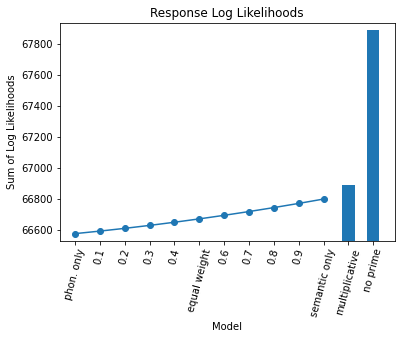

In [10]:
x = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
y = -1 * rgroup['rLL']


values = ['phon. only', '0.1', '0.2', '0.3','0.4','equal weight', '0.6', '0.7', '0.8', '0.9', 'semantic only', 'multiplicative', 'no prime'] 

plt.plot(x[:11],y[:1.0],marker="o")
plt.bar(x[11:],y[1.1:], width=.05)
plt.ylim(min(y)-45, max(y)+45)
plt.xlabel("Model")
plt.ylabel("Sum of Negative Log Likelihoods")
plt.title("Response Negative Log Likelihoods")
plt.xticks(x,values, rotation=75)
plt.show()

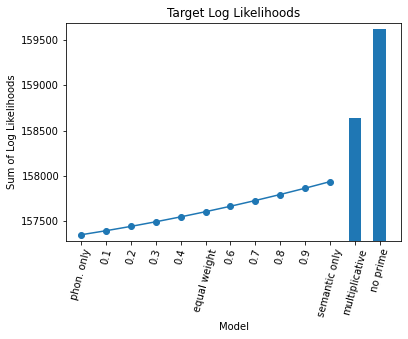

In [12]:

y = -1* tgroup['tLL']

values = ['phon. only', '0.1', '0.2', '0.3','0.4','equal weight', '0.6', '0.7', '0.8', '0.9', 'semantic only', 'multiplicative', 'no prime'] 

plt.plot(x[:11],y[:1.0],marker="o")
plt.bar(x[11:],y[1.1:], width=.05)
plt.ylim(min(y)-65, max(y)+65)
plt.xlabel("Model")
plt.ylabel("Sum of Negative Log Likelihoods")
plt.title("Target Negative Log Likelihoods")
plt.xticks(x,values, rotation=75)
plt.show()

In [ ]:
tgroup.index

Float64Index([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2], dtype='float64', name='theta')

In [ ]:
tgroup.loc[ 0:1 , 'k'] = 4
tgroup.loc[1.1 , 'k'] = 3
tgroup.loc[1.2 , 'k'] = 1
rgroup.loc[ 0:1 , 'k'] = 4
rgroup.loc[1.1 , 'k'] = 3
rgroup.loc[1.2 , 'k'] = 1

In [ ]:
import math
tgroup["BIC"] = (tgroup["k"]*math.log(17400)) - (2*tgroup['tLL'])
rgroup["BIC"] = (rgroup["k"]*math.log(7391)) - (2*rgroup['rLL']) # change to 17400 - (7537 + 2472)

In [ ]:
tgroup.sort_values(by='BIC')

,tLL,k,BIC
theta,,,
0.0,-157349.028571,4.0,314737.114044
0.1,-157393.653068,4.0,314826.363037
0.2,-157441.412558,4.0,314921.882017
0.3,-157492.294248,4.0,315023.645398
0.4,-157546.285483,4.0,315131.627868
0.5,-157603.373742,4.0,315245.804387
0.6,-157663.546637,4.0,315366.150177
0.7,-157726.791907,4.0,315492.640716
0.8,-157793.097417,4.0,315625.251737


In [ ]:
rgroup.sort_values(by='BIC')

,rLL,k,BIC
theta,,,
0.0,-66575.328578,4.0,133186.289230
0.1,-66591.744531,4.0,133219.121135
0.2,-66609.494025,4.0,133254.620123
0.3,-66628.571666,4.0,133292.775406
0.4,-66648.972119,4.0,133333.576311
0.5,-66670.690102,4.0,133377.012277
0.6,-66693.720390,4.0,133423.072853
0.7,-66718.057811,4.0,133471.747696
0.8,-66743.697247,4.0,133523.026568


In [ ]:
rgroup.to_csv("/content/drive/My Drive/LexicalRetrieval-2021/ResponseBIC.csv")
tgroup.to_csv("/content/drive/My Drive/LexicalRetrieval-2021/TargetBIC.csv")

# zRT vs. activation

In [ ]:

## first trim
rtdata = julie_files[(julie_files['FreeResp.RT']>200) & (julie_files['FreeResp.RT']<10000)]
## calculating mean and sd for each participant
subject_rt = rtdata.groupby('Subject', as_index=False).agg({'FreeResp.RT': ['mean', 'std']})


In [ ]:
len(julie_files)

17400

In [ ]:
len(rtdata)

16805

In [ ]:
(17400-16805)/17400

0.034195402298850576

In [ ]:
subject_rt.columns = subject_rt.columns.droplevel()
subject_rt.rename(columns={'':'Subject'}, inplace=True)

In [ ]:
rtdata

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,StudyNo,AgeGroup,PrimeInstruction,ExperimentName,Subject,Procedure,Trial,Both,Neither,Phonological,Semantic,Prime,PrimeCondition,Question.RESP,State.RT,FreeResp,Resp,FreeResp.RT,NewAccuracy,Accuracy,FreeRespPrimeIntrusion,Target,MCCorrect,McResp,McAcc,McRT,a,b,c,d,e,McActualResp,WhichPrime,ToEliminate,prompt,both_prompt,neither_prompt,sem_prompt,phon_prompt,prime_prompt,target_prompt,resp_prompt,target_both,target_neither,target_sem,target_phon,target_prime,target_resp,lev_target_both,lev_target_neither,lev_target_sem,lev_target_phon,lev_target_prime,lev_target_resp
0,0,0,0,6,Old,NotThePrime,tot not the prime,701,ExpProc1,1,avoid,dove,absolve,refuse,ABSOLVE,P,2,0,0,12345,1527,0,0,0,abstain,c,NaN,0,0,refuse,dove,abstain,absolve,avoid,0,X,0,To refrain deliberately and often with an effo...,0.066920,-0.033121,0.171530,0.127612,0.127612,0.125816,NaN,0.312840,0.089485,0.464569,0.217932,0.217932,NaN,0.166667,0.000000,0.000000,0.333333,0.333333,NaN
1,1,1,1,6,Old,NotThePrime,tot not the prime,701,ExpProc1,2,Norderstedt,image,neurosurgery,Berlin,NORDERSTEDT,B,2,6947,0,12345,1060,0,0,0,Nuremberg,d,d,1,7385,Norderstedt,Berlin,image,Nuremberg,neurosurgery,Nuremberg,0,0,German city for which antisemitic laws were na...,0.020833,-0.096533,0.164941,0.021730,0.020833,0.225719,NaN,0.180054,0.007681,0.428896,0.328091,0.180054,NaN,0.142857,0.125000,0.000000,0.333333,0.142857,NaN
3,3,3,3,6,Old,NotThePrime,tot not the prime,701,ExpProc1,4,Saigon,thigh,sofa,Tokyo,THIGH,U,1,4833,seoul,Seoul,3272,1,1,0,Seoul,b,b,1,4168,sofa,Seoul,Saigon,thigh,Tokyo,Seoul,0,0,Capital of South Korea,0.270083,0.000034,0.378604,0.100953,0.000034,0.609253,0.609253,0.424191,0.144735,0.464015,0.166060,0.144735,1.000000,0.200000,0.000000,0.200000,0.500000,0.000000,1.000000
4,4,4,4,6,Old,NotThePrime,tot not the prime,701,ExpProc1,5,Heinola,shop,handkerchief,Oslo,OSLO,R,1,7553,helsinki,Helsinki,3497,1,1,0,Helsinki,d,d,1,3366,Heinola,Oslo,shop,Helsinki,handkerchief,Helsinki,0,0,Capital of Finland,0.034701,-0.015010,0.383043,-0.002959,0.383043,0.575294,0.575294,0.222391,0.110593,0.546045,0.080330,0.546045,1.000000,0.125000,0.000000,0.125000,0.125000,0.125000,1.000000
5,5,5,5,6,Old,NotThePrime,tot not the prime,701,ExpProc1,6,twitch,weak,tip,jerk,WEAK,U,1,4089,tic,tic,1724,1,1,0,tic,a,a,1,2134,tic,tip,jerk,twitch,weak,tic,0,0,A habitual spastic motion of particular muscle...,0.159844,0.056092,0.229959,-0.034716,0.056092,0.025288,0.025288,0.295169,0.120406,0.111691,0.185589,0.120406,1.000000,0.500000,0.333333,0.333333,0.666667,0.333333,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17395,17395,17395,17395,1,Young,NoInstruction,tot 48 ms,44,ExpProc4,96,twitch,weak,tip,jerk,twitch,B,3,4551,twitch{SPACE},twitch,2451,0,0,NaN,tic,a,d,0,1303,tic,tip,jerk,twitch,weak,twitch,B,0,A habitual spastic motion of particular muscle...,0.159844,0.056092,0.229959,-0.034716,0.159844,0.025288,0.159844,0.295169,0.120406,0.111691,0.185589,0.295169,0.295169,0.500000,0.333333,0.333333,0.666667,0.500000,0.500000
17396,17396,17396,17396,1,Young,NoInstruction,tot 48 ms,44,ExpProc4,97,typhoon,grow,turmeric,hurricane,typhoon,B,1,1708,tsunami{SPACE},tsunami,2945,1,1,NaN,tsunami,a,a,1,1237,tsunami,turmeric,hurricane,typhoon,grow,tsunami,0,0,The proper name for a tidal\twave,0.069265,0.083020,0.028776,0.027943,0.069265,0.022911,0.022911,0.541872,0.193197,0.469321,0.051463,0.541872,1.000000,0.142857,0.000000,0.000000,0.100000,0.142857,1.000000
17397,17397,17397,17397,1,Young,NoInstruction,tot 48 ms,44,ExpProc4,98,Wilson,ball,wattage,Doyle,Wilson,B,1,5276,{SHIFT}Wagner{SPACE},Wagner,2528,0,0,NaN,Watson,a,a,1,3346,Watson,wattage,Doyle,Wilson,ball,Watson,0,0,Last name of Sherlock Holmes' assistant and fr...,0.158221,0.101450,0.342255,-0.037300,0.158221,0.350901,0.116549,0.406117,0.3318

In [ ]:
subject_rt

,Subject,mean,std
0,9,1301.250000,1260.968822
1,10,1870.323232,1461.617805
2,11,2642.500000,2362.031622
3,12,2510.640000,1887.217312
4,13,2313.560000,1799.150862
...,...,...,...
169,730,540.450000,528.861544
170,731,2153.958333,2504.696817
171,732,2364.280000,1426.621290
172,733,1606.520000,1830.524634


In [ ]:
## filtering above/below 3sd and zscoring
rtdata = rtdata.merge(subject_rt, on='Subject', how='left')
print(len(rtdata))
rtdata['zRT1'] = (rtdata['FreeResp.RT'] - rtdata['mean'])/rtdata['std']
rtdata = rtdata[(rtdata['zRT1']> -3) & (rtdata['zRT1']< 3)]
print(len(rtdata))

subject_rt1 = rtdata.groupby('Subject', as_index=False).agg({'FreeResp.RT': ['mean', 'std']})
subject_rt1.columns = subject_rt1.columns.droplevel()
subject_rt1.rename(columns={'':'Subject', 'mean': 'mean1', 'std': 'std1'}, inplace=True)
rtdata = rtdata.merge(subject_rt1, on='Subject', how='left')

rtdata['zRT'] = (rtdata['FreeResp.RT'] - rtdata['mean1'])/rtdata['std1']
print(len(rtdata))


16805
16471
16471


In [ ]:
(1527 - 2255.20202)/2466.733683	

-0.29520901466524474

In [ ]:
rtdata

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,StudyNo,AgeGroup,PrimeInstruction,ExperimentName,Subject,Procedure,Trial,Both,Neither,Phonological,Semantic,Prime,PrimeCondition,Question.RESP,State.RT,FreeResp,Resp,FreeResp.RT,NewAccuracy,Accuracy,FreeRespPrimeIntrusion,Target,MCCorrect,McResp,McAcc,McRT,a,b,c,d,e,McActualResp,WhichPrime,ToEliminate,prompt,both_prompt,neither_prompt,sem_prompt,phon_prompt,prime_prompt,target_prompt,resp_prompt,target_both,target_neither,target_sem,target_phon,target_prime,target_resp,lev_target_both,lev_target_neither,lev_target_sem,lev_target_phon,lev_target_prime,lev_target_resp,mean,std,zRT1,mean1,std1,zRT
0,0,0,0,6,Old,NotThePrime,tot not the prime,701,ExpProc1,1,avoid,dove,absolve,refuse,ABSOLVE,P,2,0,0,12345,1527,0,0,0,abstain,c,NaN,0,0,refuse,dove,abstain,absolve,avoid,0,X,0,To refrain deliberately and often with an effo...,0.066920,-0.033121,0.171530,0.127612,0.127612,0.125816,NaN,0.312840,0.089485,0.464569,0.217932,0.217932,NaN,0.166667,0.000000,0.000000,0.333333,0.333333,NaN,1991.333333,1986.283648,-0.233770,1787.053763,1650.275526,-0.157582
1,1,1,1,6,Old,NotThePrime,tot not the prime,701,ExpProc1,2,Norderstedt,image,neurosurgery,Berlin,NORDERSTEDT,B,2,6947,0,12345,1060,0,0,0,Nuremberg,d,d,1,7385,Norderstedt,Berlin,image,Nuremberg,neurosurgery,Nuremberg,0,0,German city for which antisemitic laws were na...,0.020833,-0.096533,0.164941,0.021730,0.020833,0.225719,NaN,0.180054,0.007681,0.428896,0.328091,0.180054,NaN,0.142857,0.125000,0.000000,0.333333,0.142857,NaN,1991.333333,1986.283648,-0.468882,1787.053763,1650.275526,-0.440565
2,3,3,3,6,Old,NotThePrime,tot not the prime,701,ExpProc1,4,Saigon,thigh,sofa,Tokyo,THIGH,U,1,4833,seoul,Seoul,3272,1,1,0,Seoul,b,b,1,4168,sofa,Seoul,Saigon,thigh,Tokyo,Seoul,0,0,Capital of South Korea,0.270083,0.000034,0.378604,0.100953,0.000034,0.609253,0.609253,0.424191,0.144735,0.464015,0.166060,0.144735,1.000000,0.200000,0.000000,0.200000,0.500000,0.000000,1.000000,1991.333333,1986.283648,0.644755,1787.053763,1650.275526,0.899817
3,4,4,4,6,Old,NotThePrime,tot not the prime,701,ExpProc1,5,Heinola,shop,handkerchief,Oslo,OSLO,R,1,7553,helsinki,Helsinki,3497,1,1,0,Helsinki,d,d,1,3366,Heinola,Oslo,shop,Helsinki,handkerchief,Helsinki,0,0,Capital of Finland,0.034701,-0.015010,0.383043,-0.002959,0.383043,0.575294,0.575294,0.222391,0.110593,0.546045,0.080330,0.546045,1.000000,0.125000,0.000000,0.125000,0.125000,0.125000,1.000000,1991.333333,1986.283648,0.758032,1787.053763,1650.275526,1.036158
4,5,5,5,6,Old,NotThePrime,tot not the prime,701,ExpProc1,6,twitch,weak,tip,jerk,WEAK,U,1,4089,tic,tic,1724,1,1,0,tic,a,a,1,2134,tic,tip,jerk,twitch,weak,tic,0,0,A habitual spastic motion of particular muscle...,0.159844,0.056092,0.229959,-0.034716,0.056092,0.025288,0.025288,0.295169,0.120406,0.111691,0.185589,0.120406,1.000000,0.500000,0.333333,0.333333,0.666667,0.333333,1.000000,1991.333333,1986.283648,-0.134590,1787.053763,1650.275526,-0.038208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16466,17395,17395,17395,1,Young,NoInstruction,tot 48 ms,44,ExpProc4,96,twitch,weak,tip,jerk,twitch,B,3,4551,twitch{SPACE},twitch,2451,0,0,NaN,tic,a,d,0,1303,tic,tip,jerk,twitch,weak,twitch,B,0,A habitual spastic motion of particular muscle...,0.159844,0.056092,0.229959,-0.034716,0.159844,0.025288,0.159844,0.295169,0.120406,0.111691,0.185589,0.295169,0.295169,0.500000,0.333333,0.333333,0.666667,0.500000,0.500000,3248.606061,1914.015369,-0.416719,3189.234694,1829.932734,-0.403422
16467,17396,17396,17396,1,Young,NoInstruction,tot 48 ms,44,ExpProc4,97,typhoon,grow,turmeric,hurricane,typhoon,B,1,1708,tsunami{SPACE},tsunami,2945,1,1,NaN,tsunami,a,a,1,1237,tsunami,turmeric,hurricane,typhoon,grow,tsunami,0,0,The proper name for a tidal\twave,0.069265,0.083020,0.028776,0.027943,0.069265,0.022911,0.022

In [ ]:
## checking
subject_rt = rtdata.groupby('Subject').agg({'zRT': ['mean', 'std']})



In [ ]:
subject_rt

zRT     
                 mean  std
Subject                   
9        2.832202e-17  1.0
10      -3.820006e-17  1.0
11      -1.262148e-16  1.0
12      -1.076580e-16  1.0
13      -1.063964e-16  1.0
...               ...  ...
730      5.264975e-17  1.0
731      3.861645e-17  1.0
732      2.242875e-18  1.0
733     -6.797284e-18  1.0
735      8.621945e-17  1.0

[174 rows x 2 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9c1ca04050>]],
      dtype=object)

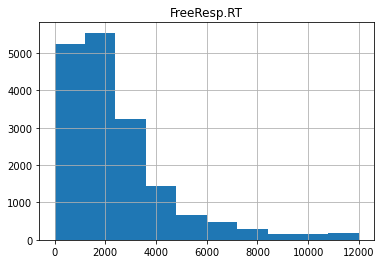

In [ ]:
julie_files.hist(column = 'FreeResp.RT')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9c1cafa390>,
      dtype=object)

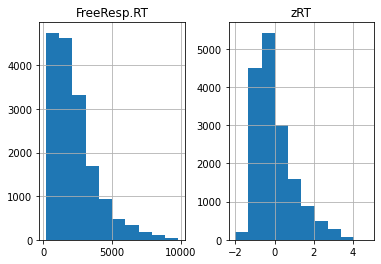

In [ ]:
rtdata.hist(column=['FreeResp.RT', 'zRT'])

In [ ]:
# TODO: 
# - merge zRT column with response likelihood 
# - group by theta 
# - for each group, plot zRT vs. likelihood in a different color
# - superimpose linear regression lines for each 
# - save a table with theta, r-value, R^2 and p-value 
# ----------




In [ ]:
respLLdf = pd.read_csv("/content/drive/My Drive/LexicalRetrieval-2021/ResponseLogLikelihoods.csv")

In [ ]:
respLLdf.drop(columns='Unnamed: 0', inplace=True)
respLLdf.rename(columns = {'resp':'Resp', 'prime': 'ActualPrime'}, inplace=True)
rtdata['ActualPrime'] = np.where(rtdata['PrimeCondition'] == 'P', rtdata['Phonological'], 
                                      np.where(rtdata['PrimeCondition'] == 'B', rtdata['Both'], 
                                               np.where(rtdata['PrimeCondition'] == 'R', rtdata['Semantic'],rtdata['Neither']))) 
rtdata['prompt'] = rtdata['prompt'].str.replace('\t',' ')                                      
rtdata['prompt'] = rtdata['prompt'].str.strip()
RTactmerge = rtdata.merge(respLLdf[['prompt', 'ActualPrime', 'Resp','theta', 'likelihood']])

In [ ]:
RTactmerge.head(20)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,StudyNo,AgeGroup,PrimeInstruction,ExperimentName,Subject,Procedure,Trial,Both,Neither,Phonological,Semantic,Prime,PrimeCondition,Question.RESP,State.RT,FreeResp,Resp,FreeResp.RT,NewAccuracy,Accuracy,FreeRespPrimeIntrusion,Target,MCCorrect,McResp,McAcc,McRT,a,b,c,d,e,McActualResp,WhichPrime,ToEliminate,prompt,both_prompt,neither_prompt,sem_prompt,phon_prompt,prime_prompt,target_prompt,resp_prompt,target_both,target_neither,target_sem,target_phon,target_prime,target_resp,lev_target_both,lev_target_neither,lev_target_sem,lev_target_phon,lev_target_prime,lev_target_resp,ActualPrime,mean,std,zRT1,mean1,std1,zRT,theta,likelihood
0,3,3,3,6,Old,NotThePrime,tot not the prime,701,ExpProc1,4,Saigon,thigh,sofa,Tokyo,THIGH,U,1,4833,seoul,Seoul,3272,1,1,0,Seoul,b,b,1,4168,sofa,Seoul,Saigon,thigh,Tokyo,Seoul,0,0,Capital of South Korea,0.270083,0.000034,0.378604,0.100953,0.000034,0.609253,0.609253,0.424191,0.144735,0.464015,0.16606,0.144735,1.0,0.2,0.0,0.2,0.5,0.0,1.0,thigh,1991.333333,1986.283648,0.644755,1787.053763,1650.275526,0.899817,0.0,0.000124
1,3,3,3,6,Old,NotThePrime,tot not the prime,701,ExpProc1,4,Saigon,thigh,sofa,Tokyo,THIGH,U,1,4833,seoul,Seoul,3272,1,1,0,Seoul,b,b,1,4168,sofa,Seoul,Saigon,thigh,Tokyo,Seoul,0,0,Capital of South Korea,0.270083,0.000034,0.378604,0.100953,0.000034,0.609253,0.609253,0.424191,0.144735,0.464015,0.16606,0.144735,1.0,0.2,0.0,0.2,0.5,0.0,1.0,thigh,1991.333333,1986.283648,0.644755,1787.053763,1650.275526,0.899817,0.1,0.000125
2,3,3,3,6,Old,NotThePrime,tot not the prime,701,ExpProc1,4,Saigon,thigh,sofa,Tokyo,THIGH,U,1,4833,seoul,Seoul,3272,1,1,0,Seoul,b,b,1,4168,sofa,Seoul,Saigon,thigh,Tokyo,Seoul,0,0,Capital of South Korea,0.270083,0.000034,0.378604,0.100953,0.000034,0.609253,0.609253,0.424191,0.144735,0.464015,0.16606,0.144735,1.0,0.2,0.0,0.2,0.5,0.0,1.0,thigh,1991.333333,1986.283648,0.644755,1787.053763,1650.275526,0.899817,0.2,0.000125
3,3,3,3,6,Old,NotThePrime,tot not the prime,701,ExpProc1,4,Saigon,thigh,sofa,Tokyo,THIGH,U,1,4833,seoul,Seoul,3272,1,1,0,Seoul,b,b,1,4168,sofa,Seoul,Saigon,thigh,Tokyo,Seoul,0,0,Capital of South Korea,0.270083,0.000034,0.378604,0.100953,0.000034,0.609253,0.609253,0.424191,0.144735,0.464015,0.16606,0.144735,1.0,0.2,0.0,0.2,0.5,0.0,1.0,thigh,1991.333333,1986.283648,0.644755,1787.053763,1650.275526,0.899817,0.3,0.000125
4,3,3,3,6,Old,NotThePrime,tot not the prime,701,ExpProc1,4,Saigon,thigh,sofa,Tokyo,THIGH,U,1,4833,seoul,Seoul,3272,1,1,0,Seoul,b,b,1,4168,sofa,Seoul,Saigon,thigh,Tokyo,Seoul,0,0,Capital of South Korea,0.270083,0.000034,0.378604,0.100953,0.000034,0.609253,0.609253,0.424191,0.144735,0.464015,0.16606,0.144735,1.0,0.2,0.0,0.2,0.5,0.0,1.0,thigh,1991.333333,1986.283648,0.644755,1787.053763,1650.275526,0.899817,0.4,0.000126
5,3,3,3,6,Old,NotThePrime,tot not the prime,701,ExpProc1,4,Saigon,thigh,sofa,Tokyo,THIGH,U,1,4833,seoul,Seoul,3272,1,1,0,Seoul,b,b,1,4168,sofa,Seoul,Saigon,thigh,Tokyo,Seoul,0,0,Capital of South Korea,0.270083,0.000034,0.378604,0.100953,0.000034,0.609253,0.609253,0.424191,0.144735,0.464015,0.16606,0.144735,1.0,0.2,0.0,0.2,0.5,0.0,1.0,thigh,1991.333333,1986.283648,0.644755,1787.053763,1650.275526,0.899817,0.5,0.000126
6,3,3,3,6,Old,NotThePrime,tot not the prime,701,ExpProc1,4,Saigon,thigh,sofa,Tokyo,THIGH,U,1,4833,seoul,Seoul,3272,1,1,0,Seoul,b,b,1,4168,sofa,Seoul,Saigon,thigh,Tokyo,Seoul,0,0,Capital of South Korea,0.270083,0.000034,0.378604,0.100953,0.000034,0.609253,0.609253,0.424191,0.144735,0.464015,0.16606,0.144735,1.0,0.2,0.0,0.2,0.5,0.0,1.0,thigh,1991.333333,1986.283648,0.644755,1787.053763,1650.275526,0.899817,0.6,0.000126
7,3,3,3,6,Old,NotThePrime,tot not the prime,701,ExpProc1,4,Saigon,thigh,sofa,Tokyo,THIGH,U,1,4833,seoul,Seoul,3272,1,1,0,Seoul,b,b,1,4168,sofa,Seoul,Saigon,thigh,Tokyo,Seoul,0,0,Capital of South Korea,0.270083,0.000034,0.378604,0.100953,0.000034,0.609253,0.609253,0.424191,0.144735,0.464015,0.16606,0.144735,1.0,0.2,0.0,0.2,0.5,0.0,1.0,thigh,1991.333333,1986.283648,0.644755,1787.05

In [ ]:
RTactmerge.drop_duplicates(inplace=True)


In [ ]:
byT = RTactmerge[['theta', 'prompt', 'ActualPrime', 'Resp', 'Subject','zRT', 'likelihood']].groupby('theta')

In [ ]:
byT.get_group(1.1)

,theta,prompt,ActualPrime,Resp,Subject,zRT,likelihood
11,1.1,Capital of South Korea,thigh,Seoul,701,0.899817,0.000134
284,1.1,Capital of South Korea,thigh,Seoul,709,0.218779,0.000134
557,1.1,Capital of South Korea,thigh,Seoul,165,-0.366932,0.000134
830,1.1,Capital of South Korea,thigh,Seoul,169,-0.081982,0.000134
1103,1.1,Capital of South Korea,thigh,Seoul,173,2.388901,0.000134
...,...,...,...,...,...,...,...
1005587,1.1,To plead the cause of another; to support or p...,plank,advertise,44,0.373656,0.000086
1005600,1.1,Identical in form; coinciding exactly when sup...,cognizant,alike,44,-0.092481,0.000104
1005613,1.1,To raise into position by means of a pulley,dredge,dredge,44,0.152883,0.000207
1005626,1.1,A distinctive or peculiar feature or character...,uniqueness,nickname,44,-0.083191,0.000091


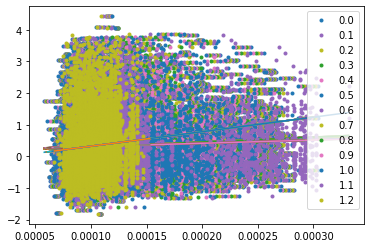

In [ ]:
# TODO: lin. regressions for each theta, add and mult
linregs = {}
x = np.linspace(byT['likelihood'].min(), byT['likelihood'].max(), 100)
for name, group in byT:
  linregs[name] = stats.linregress(group['likelihood'], group['zRT'])
  plt.plot(group['likelihood'], group['zRT'], marker=".", linestyle="", label=name)
  plt.plot(x, linregs[name].intercept + linregs[name].slope*x)
plt.legend()
plt.show()

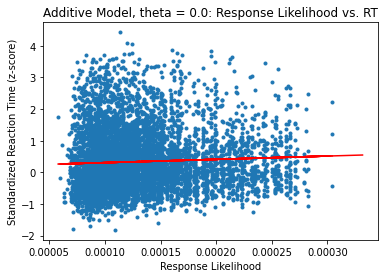

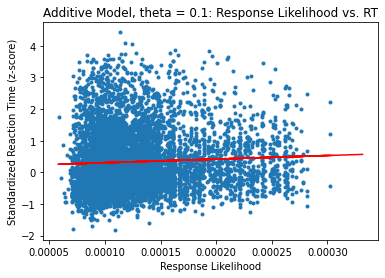

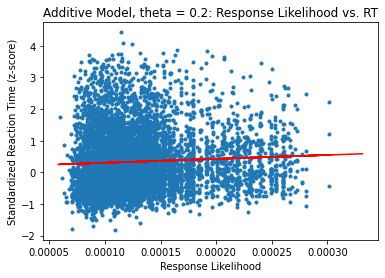

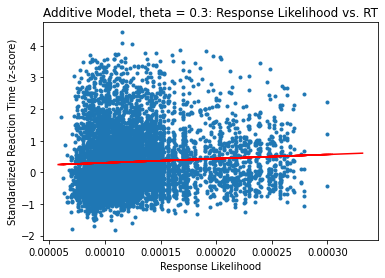

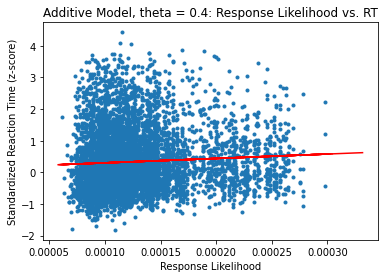

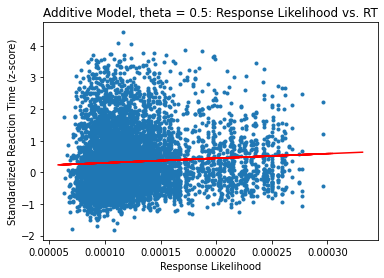

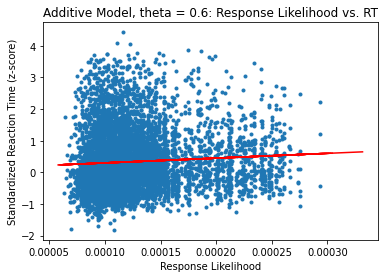

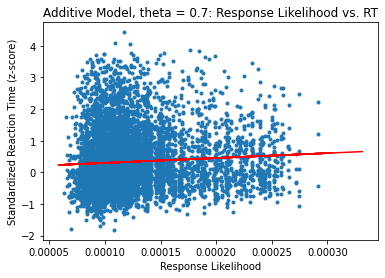

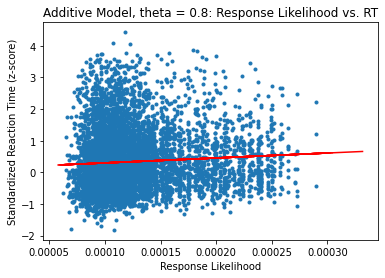

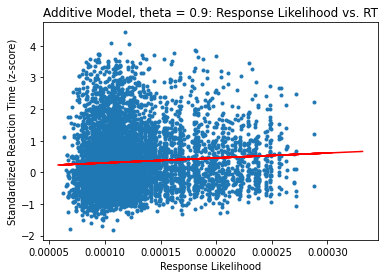

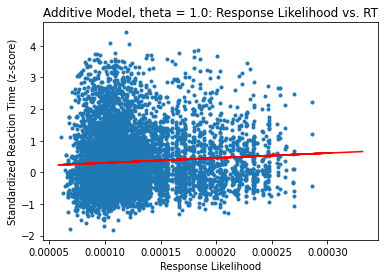

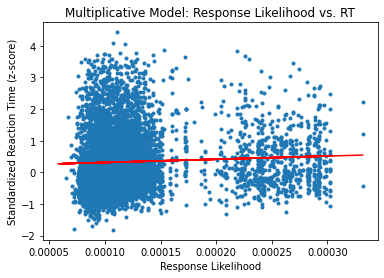

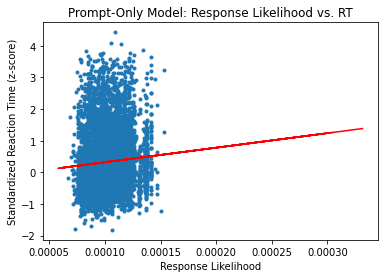

In [ ]:
for name, group in byT:
  linregs[name] = stats.linregress(group['likelihood'], group['zRT'])
  plt.plot(group['likelihood'], group['zRT'], marker=".", linestyle="", label=name)
  plt.plot(x, linregs[name].intercept + linregs[name].slope*x, "r")
  plt.xlabel('Response Likelihood')
  plt.ylabel('Standardized Reaction Time (z-score)')
  if name < 1.1:
    plt.title('Additive Model, theta = '+ str(name) + ': Response Likelihood vs. RT')
  if name == 1.1:
    plt.title('Multiplicative Model: Response Likelihood vs. RT')
  if name == 1.2:
    plt.title('Prompt-Only Model: Response Likelihood vs. RT')
  plt.show()

In [ ]:
linregtable = pd.DataFrame.from_dict(linregs, orient='index')

In [ ]:
linregtable['R-squared'] = linregtable['rvalue'] ** 2
linregtable

,slope,intercept,rvalue,pvalue,stderr,R-squared
0.0,1041.931691,0.200723,0.050153,2.269872e-05,245.775657,0.002515
0.1,1136.776141,0.189275,0.052960,7.679009e-06,253.900886,0.002805
0.2,1228.781769,0.178269,0.055592,2.644694e-06,261.418088,0.003090
0.3,1315.132409,0.168047,0.057998,9.570170e-07,268.143758,0.003364
0.4,1392.808768,0.158969,0.060127,3.766016e-07,273.894500,0.003615
0.5,1458.809395,0.151390,0.061928,1.668786e-07,278.499397,0.003835
0.6,1510.420731,0.145624,0.063359,8.599906e-08,281.813660,0.004014
0.7,1545.497414,0.141914,0.064388,5.292530e-08,283.731663,0.004146
0.8,1562.702023,0.140399,0.064996,3.959645e-08,284.197231,0.004224
0.9,1561.654862,0.141104,0.065178,3.627732e-08,283.209218,0.004248


In [ ]:
linregtable.index.rename('theta', inplace=True)

In [ ]:
linregtable

,slope,intercept,rvalue,pvalue,stderr,R-squared
theta,,,,,,
0.0,1041.931691,0.200723,0.050153,2.269872e-05,245.775657,0.002515
0.1,1136.776141,0.189275,0.052960,7.679009e-06,253.900886,0.002805
0.2,1228.781769,0.178269,0.055592,2.644694e-06,261.418088,0.003090
0.3,1315.132409,0.168047,0.057998,9.570170e-07,268.143758,0.003364
0.4,1392.808768,0.158969,0.060127,3.766016e-07,273.894500,0.003615
0.5,1458.809395,0.151390,0.061928,1.668786e-07,278.499397,0.003835
0.6,1510.420731,0.145624,0.063359,8.599906e-08,281.813660,0.004014
0.7,1545.497414,0.141914,0.064388,5.292530e-08,283.731663,0.004146
0.8,1562.702023,0.140399,0.064996,3.959645e-08,284.197231,0.004224


In [ ]:
linregtable.to_csv("/content/drive/My Drive/LexicalRetrieval-2021/zRTvsResponseLikelihoodRegressionOutput.csv")

In [ ]:
singlegrp = RTactmerge[(RTactmerge['PrimeInstruction'] == 'NotThePrime')&(RTactmerge['AgeGroup'] == 'Young')]

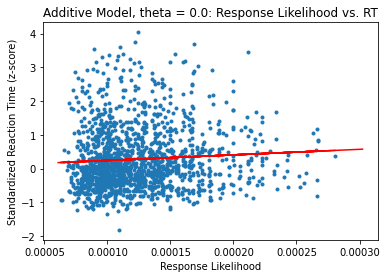

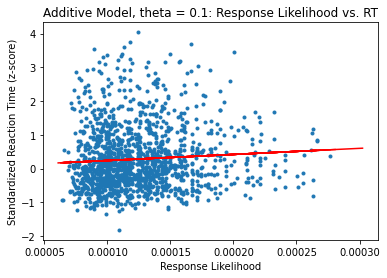

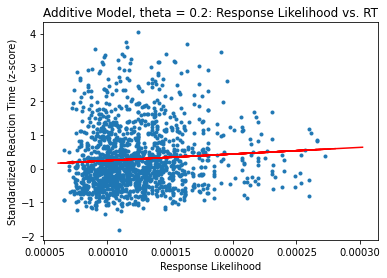

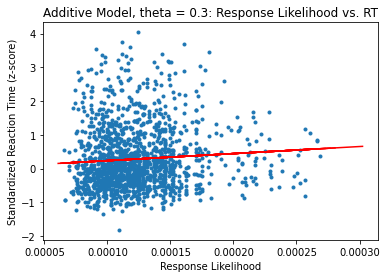

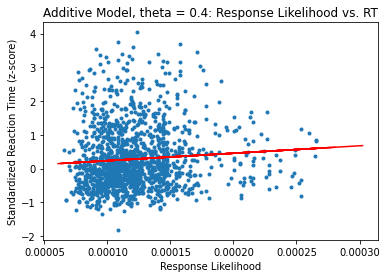

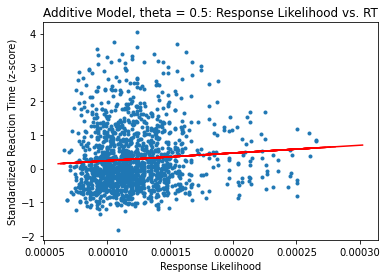

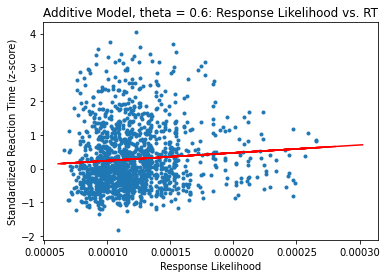

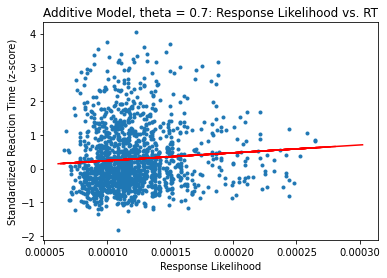

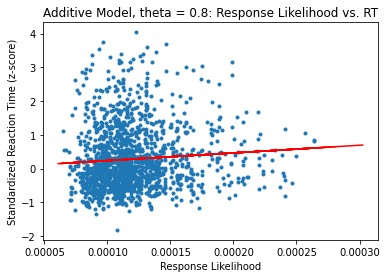

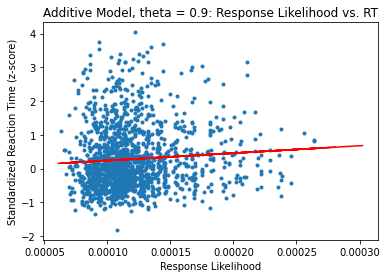

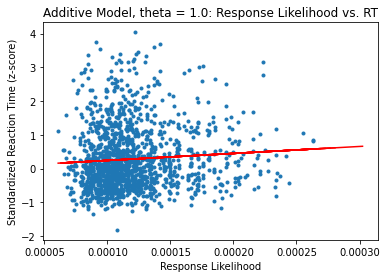

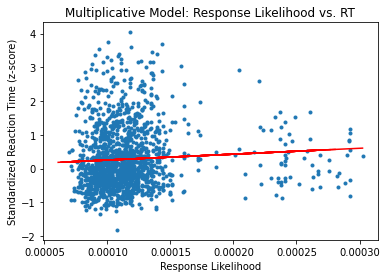

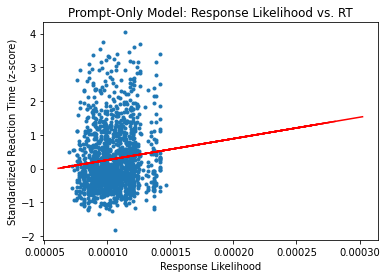

In [ ]:
byT1 = singlegrp[['theta', 'prompt', 'ActualPrime', 'Resp', 'Subject','zRT', 'likelihood']].groupby('theta')
linregs1 = {}
x = np.linspace(byT1['likelihood'].min(), byT1['likelihood'].max(), 100)
for name, group in byT1:
  linregs1[name] = stats.linregress(group['likelihood'], group['zRT'])
  plt.plot(group['likelihood'], group['zRT'], marker=".", linestyle="", label=name)
  plt.plot(x, linregs1[name].intercept + linregs1[name].slope*x, "r")
  plt.xlabel('Response Likelihood')
  plt.ylabel('Standardized Reaction Time (z-score)')
  if name < 1.1:
    plt.title('Additive Model, theta = '+ str(name) + ': Response Likelihood vs. RT')
  if name == 1.1:
    plt.title('Multiplicative Model: Response Likelihood vs. RT')
  if name == 1.2:
    plt.title('Prompt-Only Model: Response Likelihood vs. RT')
  plt.show()

In [ ]:
linregtable1 = pd.DataFrame.from_dict(linregs1, orient='index')
linregtable1['R-squared'] = linregtable1['rvalue'] ** 2
linregtable1.index.rename('theta', inplace=True)
linregtable1

,slope,intercept,rvalue,pvalue,stderr,R-squared
theta,,,,,,
0.0,1648.491664,0.074288,0.066254,0.009918,638.470678,0.004390
0.1,1805.331706,0.056164,0.069139,0.007119,669.910767,0.004780
0.2,1957.206122,0.038772,0.071772,0.005207,699.498772,0.005151
0.3,2095.439254,0.023138,0.074026,0.003952,725.972614,0.005480
0.4,2210.173484,0.010413,0.075772,0.003176,747.978143,0.005741
0.5,2291.720367,0.001711,0.076891,0.002755,764.229192,0.005912
0.6,2332.359665,-0.002102,0.077293,0.002617,773.705306,0.005974
0.7,2328.065648,-0.000604,0.076941,0.002738,775.836154,0.005920
0.8,2279.501717,0.006071,0.075853,0.003144,770.611507,0.005754


# Error

In [ ]:
respLL = pd.read_csv("/content/drive/My Drive/LexicalRetrieval-2021/scripts data/ResponseLogLikelihoods.csv")

In [ ]:
respLL

,Unnamed: 0,prompt,prime,resp,modelType,theta,likelihood,rLL
0,0,Capital of South Korea,thigh,Seoul,add,0.0,0.000124,-8.991551
1,1,Capital of South Korea,thigh,Seoul,add,0.1,0.000125,-8.989074
2,2,Capital of South Korea,thigh,Seoul,add,0.2,0.000125,-8.986768
3,3,Capital of South Korea,thigh,Seoul,add,0.3,0.000125,-8.984633
4,4,Capital of South Korea,thigh,Seoul,add,0.4,0.000126,-8.982667
...,...,...,...,...,...,...,...,...
96078,96078,National park in which Old Faithful is located,Yosemite,Yellowstone,add,0.8,0.000162,-8.725265
96079,96079,National park in which Old Faithful is located,Yosemite,Yellowstone,add,0.9,0.000167,-8.696931
96080,96080,National park in which Old Faithful is located,Yosemite,Yellowstone,add,1.0,0.000172,-8.668755
96081,96081,National park in which Old Faithful is located,Yosemite,Yellowstone,mult,1.1,0.000131,-8.939942


In [ ]:
# merge NewAccuracy and prime condition from julie_files, group by NewAccuracy -> plot sum of resp log-likelihood for each theta correct vs incorrect response
# repeat grouped by prime condition
respLL.drop(columns='Unnamed: 0', inplace=True)
respLL.rename(columns = {'resp':'Resp', 'prime': 'ActualPrime'}, inplace=True)
julie_files['ActualPrime'] = np.where(julie_files['PrimeCondition'] == 'P', julie_files['Phonological'], 
                                      np.where(julie_files['PrimeCondition'] == 'B', julie_files['Both'], 
                                               np.where(julie_files['PrimeCondition'] == 'R', julie_files['Semantic'],julie_files['Neither']))) 
julie_files['prompt'] = julie_files['prompt'].str.replace('\t',' ')                                      
julie_files['prompt'] = julie_files['prompt'].str.strip()



In [ ]:
newd = respLL.merge(julie_files[['Subject', 'AgeGroup', 'ExperimentName','prompt', 'PrimeCondition', 'ActualPrime','Target', 'Resp', 'NewAccuracy', 'Question.RESP']])

In [ ]:
newd

,prompt,ActualPrime,Resp,modelType,theta,likelihood,rLL,Subject,AgeGroup,ExperimentName,PrimeCondition,Target,NewAccuracy,Question.RESP
0,Capital of South Korea,thigh,Seoul,add,0.0,0.000124,-8.991551,701,Old,tot not the prime,U,Seoul,1,1
1,Capital of South Korea,thigh,Seoul,add,0.0,0.000124,-8.991551,709,Old,tot not the prime,U,Seoul,1,1
2,Capital of South Korea,thigh,Seoul,add,0.0,0.000124,-8.991551,165,Young,tot not the prime,U,Seoul,1,1
3,Capital of South Korea,thigh,Seoul,add,0.0,0.000124,-8.991551,169,Young,tot not the prime,U,Seoul,1,1
4,Capital of South Korea,thigh,Seoul,add,0.0,0.000124,-8.991551,173,Young,tot not the prime,U,Seoul,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1032546,Having unlimited power; able to do anything,endless,limitless,add,0.8,0.000165,-8.711853,44,Young,tot 48 ms,R,omnipotent,0,1
1032547,Having unlimited power; able to do anything,endless,limitless,add,0.9,0.000165,-8.709257,44,Young,tot 48 ms,R,omnipotent,0,1
1032548,Having unlimited power; able to do anything,endless,limitless,add,1.0,0.000165,-8.706845,44,Young,tot 48 ms,R,omnipotent,0,1
1032549,Having unlimited power; able to do anything,endless,limitless,mult,1.1,0.000148,-8.818335,44,Young,tot 48 ms,R,omnipotent,0,1


In [ ]:
print(len(newd))
print(len(newd.drop_duplicates()))

1032551
96083


In [ ]:
newd.drop_duplicates(inplace=True)
newd.to_csv("/content/drive/My Drive/LexicalRetrieval-2021/scripts data/ResponseLLwithGroups.csv")

In [15]:
newd = pd.read_csv("/content/drive/My Drive/LexicalRetrieval-2021/scripts data/ResponseLLwithGroups.csv")

In [16]:
incorrect = newd[newd['NewAccuracy']==0]
correct = newd[newd['NewAccuracy']==1]
print(len(incorrect))
print(len(correct))

46605
49478


In [17]:
incorrg = incorrect[['theta', 'rLL']].groupby(['theta']).sum()
corrg = correct[['theta', 'rLL']].groupby(['theta']).sum()

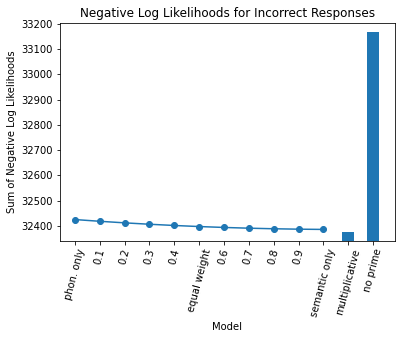

In [20]:
x = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
y = -1*incorrg['rLL']

values = ['phon. only', '0.1', '0.2', '0.3','0.4','equal weight', '0.6', '0.7', '0.8', '0.9', 'semantic only', 'multiplicative', 'no prime'] 

plt.plot(x[:11],y[:1.0],marker="o")
plt.bar(x[11:],y[1.1:], width=.05)
plt.ylim(min(y)-35, max(y)+35)
plt.xlabel("Model")
plt.ylabel("Sum of Negative Log Likelihoods")
plt.title("Negative Log Likelihoods for Incorrect Responses")
plt.xticks(x,values, rotation=75)
plt.show()

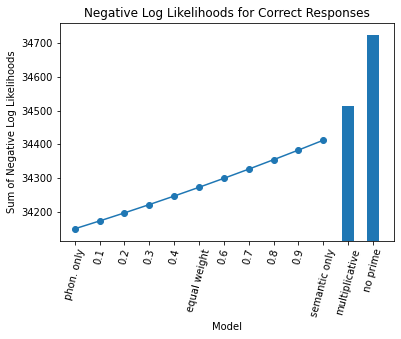

In [21]:
y = -1*corrg['rLL']

values = ['phon. only', '0.1', '0.2', '0.3','0.4','equal weight', '0.6', '0.7', '0.8', '0.9', 'semantic only', 'multiplicative', 'no prime'] 

plt.plot(x[:11], y[:1.0] ,marker="o")
axes = plt.gca()
y_min, y_max = axes.get_ylim()
plt.bar(x[11:],y[1.1:], width=.05)
plt.ylim(min(y)-35, max(y)+35)
plt.xlabel("Model")
plt.ylabel("Sum of Negative Log Likelihoods")
plt.title("Negative Log Likelihoods for Correct Responses")
plt.xticks(x,values, rotation=75)
plt.show()

# Prime Condition

In [4]:
newd = pd.read_csv("/content/drive/My Drive/LexicalRetrieval-2021/scripts data/ResponseLLwithGroups.csv")

In [22]:
phon = newd[newd['PrimeCondition']=='P']
sem = newd[newd['PrimeCondition']=='R']
both = newd[newd['PrimeCondition']=='B']
neither = newd[newd['PrimeCondition']=='U']
print(len(phon))
print(len(sem))
print(len(both))
print(len(neither))

25480
25246
24570
20787


In [23]:
phong = phon[['theta', 'rLL']].groupby(['theta']).sum()
semg = sem[['theta', 'rLL']].groupby(['theta']).sum()
bothg = both[['theta', 'rLL']].groupby(['theta']).sum()
neitherg = neither[['theta', 'rLL']].groupby(['theta']).sum()

## Phonological

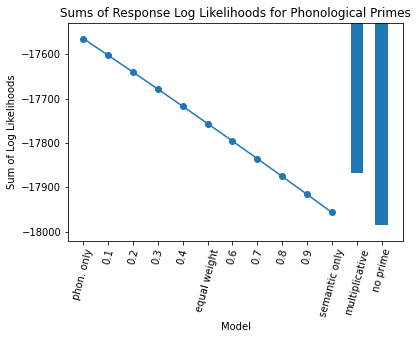

In [11]:
x = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
y = -1 * phong['rLL']

values = ['phon. only', '0.1', '0.2', '0.3','0.4','equal weight', '0.6', '0.7', '0.8', '0.9', 'semantic only', 'multiplicative', 'no prime'] 

plt.plot(x[:11],y[:1.0],marker="o")
plt.bar(x[11:],y[1.1:], width=.05)
plt.ylim(min(y)-35, max(y)+35)
plt.xlabel("Model")
plt.ylabel("Sum of Negative Log Likelihoods")
plt.title("Response Negative Log Likelihoods for Phonological Primes")
plt.xticks(x,values, rotation=75)
plt.show()

In [8]:
phong.sort_values(by='rLL', ascending=False)

,rLL
theta,
0.0,-17564.805071
0.1,-17602.417215
0.2,-17640.383952
0.3,-17678.703866
0.4,-17717.375550
0.5,-17756.397616
0.6,-17795.768688
0.7,-17835.487403
1.1,-17866.743872


In [24]:
targLL = pd.read_csv("/content/drive/My Drive/LexicalRetrieval-2021/scripts data/TargetLogLikelihoods.csv")
targLL.drop(columns='Unnamed: 0', inplace=True)
targLL.rename(columns = {'targ':'Target', 'prime': 'ActualPrime'}, inplace=True)
julie_files['ActualPrime'] = np.where(julie_files['PrimeCondition'] == 'P', julie_files['Phonological'], 
                                      np.where(julie_files['PrimeCondition'] == 'B', julie_files['Both'], 
                                               np.where(julie_files['PrimeCondition'] == 'R', julie_files['Semantic'],julie_files['Neither']))) 
julie_files['prompt'] = julie_files['prompt'].str.replace('\t',' ')                                      
julie_files['prompt'] = julie_files['prompt'].str.strip()
targ_newd = targLL.merge(julie_files[['prompt', 'PrimeCondition', 'ActualPrime','Target']])

In [25]:
targ_newd.drop_duplicates(inplace=True)

In [26]:
phon = targ_newd[targ_newd['PrimeCondition']=='P']
sem = targ_newd[targ_newd['PrimeCondition']=='R']
both = targ_newd[targ_newd['PrimeCondition']=='B']
neither = targ_newd[targ_newd['PrimeCondition']=='U']
print(len(phon))
print(len(sem))
print(len(both))
print(len(neither))

1300
1300
1300
1300


In [27]:
tphong = phon[['theta', 'tLL']].groupby(['theta']).sum()
tsemg = sem[['theta', 'tLL']].groupby(['theta']).sum()
tbothg = both[['theta', 'tLL']].groupby(['theta']).sum()
tneitherg = neither[['theta', 'tLL']].groupby(['theta']).sum()

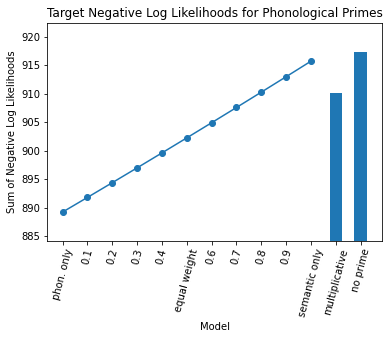

In [28]:
y = -1*tphong['tLL']

values = ['phon. only', '0.1', '0.2', '0.3','0.4','equal weight', '0.6', '0.7', '0.8', '0.9', 'semantic only', 'multiplicative', 'no prime'] 

plt.plot(x[:11],y[:1.0],marker="o")
plt.bar(x[11:],y[1.1:], width=.05)
plt.ylim(min(y)-5, max(y)+5)
plt.xlabel("Model")
plt.ylabel("Sum of Negative Log Likelihoods")
plt.title("Target Negative Log Likelihoods for Phonological Primes")
plt.xticks(x,values, rotation=75)
plt.show()

In [28]:
tphong.sort_values(by='tLL', ascending=False)

,tLL
theta,
0.0,-889.233929
0.1,-891.799878
0.2,-894.383894
0.3,-896.985907
0.4,-899.605846
0.5,-902.243643
0.6,-904.899227
0.7,-907.572532
1.1,-910.090983


## Semantic

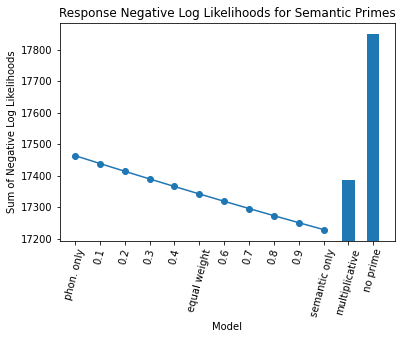

In [29]:
y = -1*semg['rLL']

values = ['phon. only', '0.1', '0.2', '0.3','0.4','equal weight', '0.6', '0.7', '0.8', '0.9', 'semantic only', 'multiplicative', 'no prime'] 

plt.plot(x[:11],y[:1.0],marker="o")
plt.bar(x[11:],y[1.1:], width=.05)
plt.ylim(min(y)-35, max(y)+35)
plt.xlabel("Model")
plt.ylabel("Sum of Negative Log Likelihoods")
plt.title("Response Negative Log Likelihoods for Semantic Primes")
plt.xticks(x,values, rotation=75)
plt.show()

In [10]:
semg.sort_values(by='rLL', ascending=False)

,rLL
theta,
1.0,-17228.347718
0.9,-17250.308796
0.8,-17272.603163
0.7,-17295.231989
0.6,-17318.196453
0.5,-17341.497749
0.4,-17365.137081
1.1,-17386.826624
0.3,-17389.115664


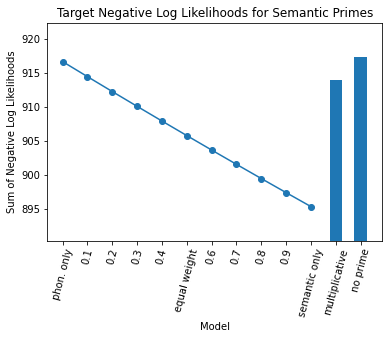

In [30]:
y = -1*tsemg['tLL']

values = ['phon. only', '0.1', '0.2', '0.3','0.4','equal weight', '0.6', '0.7', '0.8', '0.9', 'semantic only', 'multiplicative', 'no prime'] 

plt.plot(x[:11],y[:1.0],marker="o")
plt.bar(x[11:],y[1.1:], width=.05)
plt.ylim(min(y)-5, max(y)+5)
plt.xlabel("Model")
plt.ylabel("Sum of Negative Log Likelihoods")
plt.title("Target Negative Log Likelihoods for Semantic Primes")
plt.xticks(x,values, rotation=75)
plt.show()

In [38]:
tsemg.sort_values(by='tLL', ascending=False)

,tLL
theta,
1.0,-895.362195
0.9,-897.419595
0.8,-899.493988
0.7,-901.585438
0.6,-903.694008
0.5,-905.819764
0.4,-907.962772
0.3,-910.123098
0.2,-912.300809


## Both

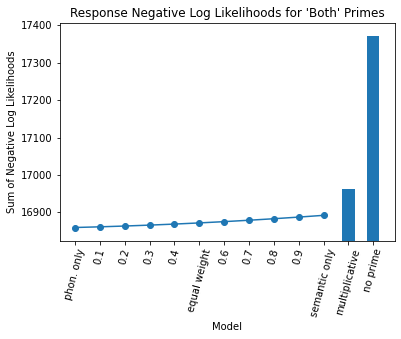

In [31]:
y = -1*bothg['rLL']

values = ['phon. only', '0.1', '0.2', '0.3','0.4','equal weight', '0.6', '0.7', '0.8', '0.9', 'semantic only', 'multiplicative', 'no prime'] 

plt.plot(x[:11],y[:1.0],marker="o")
plt.bar(x[11:],y[1.1:], width=.05)
plt.ylim(min(y)-35, max(y)+35)
plt.xlabel("Model")
plt.ylabel("Sum of Negative Log Likelihoods")
plt.title("Response Negative Log Likelihoods for 'Both' Primes")
plt.xticks(x,values, rotation=75)
plt.show()

In [32]:
bothg.sort_values(by='rLL', ascending=False)

,rLL
theta,
0.0,-16859.521771
0.1,-16861.325125
0.2,-16863.452847
0.3,-16865.903798
0.4,-16868.676848
0.5,-16871.770880
0.6,-16875.184784
0.7,-16878.917461
0.8,-16882.967821


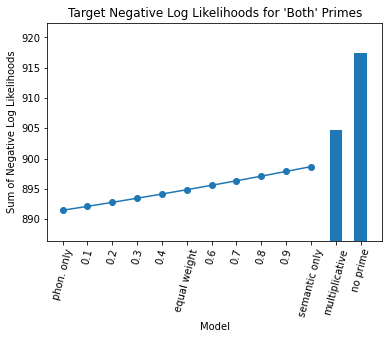

In [32]:
y = -1*tbothg['tLL']

values = ['phon. only', '0.1', '0.2', '0.3','0.4','equal weight', '0.6', '0.7', '0.8', '0.9', 'semantic only', 'multiplicative', 'no prime'] 

plt.plot(x[:11],y[:1.0],marker="o")
plt.bar(x[11:],y[1.1:], width=.05)
plt.ylim(min(y)-5, max(y)+5)
plt.xlabel("Model")
plt.ylabel("Sum of Negative Log Likelihoods")
plt.title("Target Negative Log Likelihoods for 'Both' Primes")
plt.xticks(x,values, rotation=75)
plt.show()

In [39]:
tbothg.sort_values(by='tLL', ascending=False)

,tLL
theta,
0.0,-891.504993
0.1,-892.149679
0.2,-892.811270
0.3,-893.489709
0.4,-894.184940
0.5,-894.896906
0.6,-895.625553
0.7,-896.370825
0.8,-897.132667


## Neither

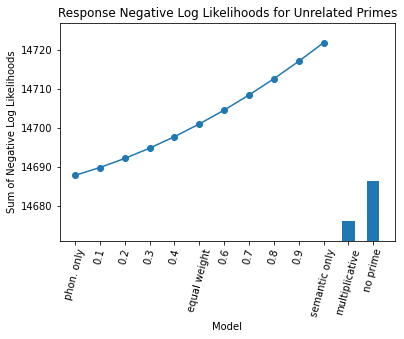

In [33]:
y = -1*neitherg['rLL']

values = ['phon. only', '0.1', '0.2', '0.3','0.4','equal weight', '0.6', '0.7', '0.8', '0.9', 'semantic only', 'multiplicative', 'no prime'] 

plt.plot(x[:11],y[:1.0],marker="o")
plt.bar(x[11:],y[1.1:], width=.05)
plt.ylim(min(y)-5, max(y)+5)
plt.xlabel("Model")
plt.ylabel("Sum of Negative Log Likelihoods")
plt.title("Response Negative Log Likelihoods for Unrelated Primes")
plt.xticks(x,values, rotation=75)
plt.show()

In [37]:
neitherg.sort_values(by='rLL', ascending=False)

,rLL
theta,
1.1,-14676.238437
1.2,-14686.400739
0.0,-14687.902464
0.1,-14689.906679
0.2,-14692.222498
0.3,-14694.848339
0.4,-14697.782639
0.5,-14701.023856
0.6,-14704.570465


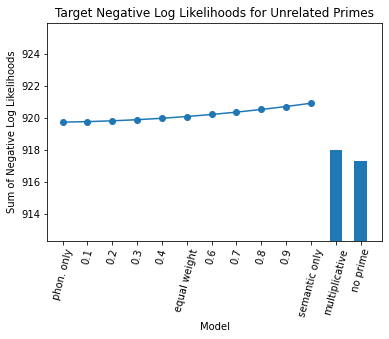

In [34]:
y = -1 * tneitherg['tLL']

values = ['phon. only', '0.1', '0.2', '0.3','0.4','equal weight', '0.6', '0.7', '0.8', '0.9', 'semantic only', 'multiplicative', 'no prime'] 

plt.plot(x[:11],y[:1.0],marker="o")
plt.bar(x[11:],y[1.1:], width=.05)
plt.ylim(min(y)-5, max(y)+5)
plt.xlabel("Model")
plt.ylabel("Sum of Negative Log Likelihoods")
plt.title("Target Negative Log Likelihoods for Unrelated Primes")
plt.xticks(x,values, rotation=75)
plt.show()

In [42]:
tneitherg.sort_values(by='tLL', ascending=False)

,tLL
theta,
1.2,-917.359741
1.1,-918.041530
0.0,-919.755833
0.1,-919.786746
0.2,-919.837239
0.3,-919.907213
0.4,-919.996571
0.5,-920.105219
0.6,-920.233062


Basically, if you're trying to predict the target with an unrelated prime, it's better to ignore the prime altogether

# Age

In [35]:
old = newd[newd['AgeGroup']=='Old']
young = newd[newd['AgeGroup']=='Young']
print(len(old))
print(len(young))

34372
61711


In [36]:
oldg = old[['theta', 'rLL']].groupby(['theta']).sum()
youngg = young[['theta', 'rLL']].groupby(['theta']).sum()

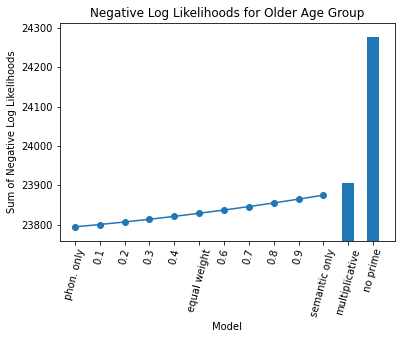

In [37]:
x = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
y = -1*oldg['rLL']

values = ['phon. only', '0.1', '0.2', '0.3','0.4','equal weight', '0.6', '0.7', '0.8', '0.9', 'semantic only', 'multiplicative', 'no prime'] 

plt.plot(x[:11],y[:1.0],marker="o")
plt.bar(x[11:],y[1.1:], width=.05)
plt.ylim(min(y)-35, max(y)+35)
plt.xlabel("Model")
plt.ylabel("Sum of Negative Log Likelihoods")
plt.title("Negative Log Likelihoods for Older Age Group")
plt.xticks(x,values, rotation=75)
plt.show()

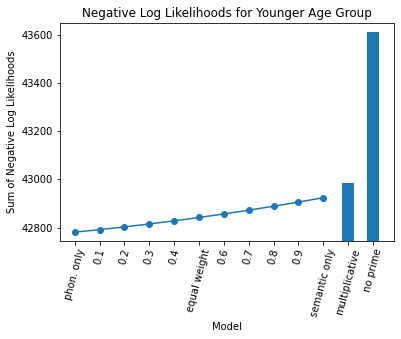

In [38]:
x = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
y = -1*youngg['rLL']

values = ['phon. only', '0.1', '0.2', '0.3','0.4','equal weight', '0.6', '0.7', '0.8', '0.9', 'semantic only', 'multiplicative', 'no prime'] 

plt.plot(x[:11],y[:1.0],marker="o")
plt.bar(x[11:],y[1.1:], width=.05)
plt.ylim(min(y)-35, max(y)+35)
plt.xlabel("Model")
plt.ylabel("Sum of Negative Log Likelihoods")
plt.title("Negative Log Likelihoods for Younger Age Group")
plt.xticks(x,values, rotation=75)
plt.show()

# Prime Duration

In [39]:
long300 = newd[(newd['ExperimentName']=='tot not the prime') | (newd['ExperimentName']=='tot extended prime')]
short48 = newd[newd['ExperimentName']=='tot 48 ms']
print(len(long300))
print(len(short48))

78598
17485


In [ ]:
long300g = long300[['theta', 'rLL']].groupby(['theta']).sum()
short48g = short48[['theta', 'rLL']].groupby(['theta']).sum()

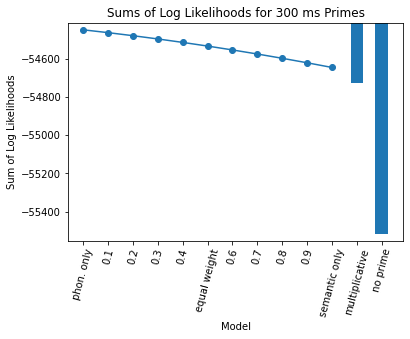

In [ ]:
x = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
y = long300g['rLL']

values = ['phon. only', '0.1', '0.2', '0.3','0.4','equal weight', '0.6', '0.7', '0.8', '0.9', 'semantic only', 'multiplicative', 'no prime'] 

plt.plot(x[:11],y[:1.0],marker="o")
plt.bar(x[11:],y[1.1:], width=.05)
plt.ylim(min(y)-35, max(y)+35)
plt.xlabel("Model")
plt.ylabel("Sum of Log Likelihoods")
plt.title("Sums of Log Likelihoods for 300 ms Primes")
plt.xticks(x,values, rotation=75)
plt.show()

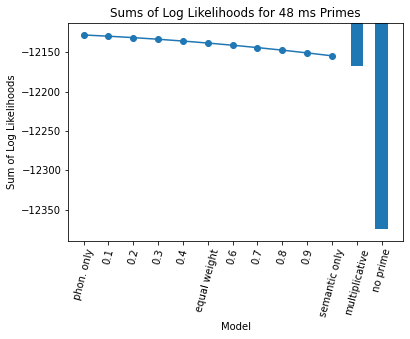

In [ ]:
x = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
y = short48g['rLL']

values = ['phon. only', '0.1', '0.2', '0.3','0.4','equal weight', '0.6', '0.7', '0.8', '0.9', 'semantic only', 'multiplicative', 'no prime'] 

plt.plot(x[:11],y[:1.0],marker="o")
plt.bar(x[11:],y[1.1:], width=.05)
plt.ylim(min(y)-15, max(y)+15)
plt.xlabel("Model")
plt.ylabel("Sum of Log Likelihoods")
plt.title("Sums of Log Likelihoods for 48 ms Primes")
plt.xticks(x,values, rotation=75)
plt.show()

# Reported State

In [40]:
know = newd[newd['Question.RESP'] == 1]
dontknow = newd[newd['Question.RESP'] == 2]
otherword = newd[newd['Question.RESP'] == 3]
tot = newd[newd['Question.RESP'] == 4]
print(len(know))
print(len(dontknow))
print(len(otherword))
print(len(tot))

70096
2015
19136
4836


In [41]:
knowg = know[['theta', 'rLL']].groupby(['theta']).sum()
dontknowg = dontknow[['theta', 'rLL']].groupby(['theta']).sum()
otherwordg = otherword[['theta', 'rLL']].groupby(['theta']).sum()
totg = tot[['theta', 'rLL']].groupby(['theta']).sum()

In [ ]:
knowg.sort_values(by='rLL', ascending=False)

,rLL
theta,
0.0,-48378.834108
0.1,-48398.458098
0.2,-48419.049247
0.3,-48440.603601
0.4,-48463.117248
0.5,-48486.586316
0.6,-48511.006973
0.7,-48536.375424
0.8,-48562.687913


In [ ]:
dontknowg.sort_values(by='rLL', ascending=False)

,rLL
theta,
0.0,-1410.324065
0.1,-1410.696243
0.2,-1411.096660
0.3,-1411.525197
0.4,-1411.981734
0.5,-1412.466154
0.6,-1412.978341
0.7,-1413.518179
0.8,-1414.085554


In [ ]:
otherwordg.sort_values(by='rLL', ascending=False)

,rLL
theta,
1.0,-13384.660023
0.9,-13385.789949
0.8,-13387.181842
0.7,-13388.836679
0.6,-13390.755449
0.5,-13392.939150
0.4,-13395.388793
0.3,-13398.105400
0.2,-13401.090004


In [ ]:
totg.sort_values(by='rLL', ascending=False)

,rLL
theta,
0.1,-3378.246538
0.2,-3378.258113
0.0,-3378.303007
0.3,-3378.337468
0.4,-3378.484344
0.5,-3378.698481
0.6,-3378.979627
0.7,-3379.327529
0.8,-3379.741937


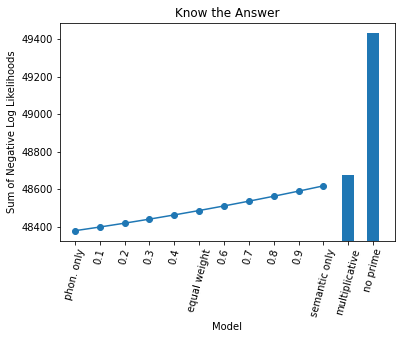

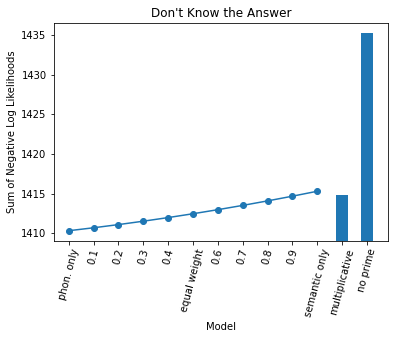

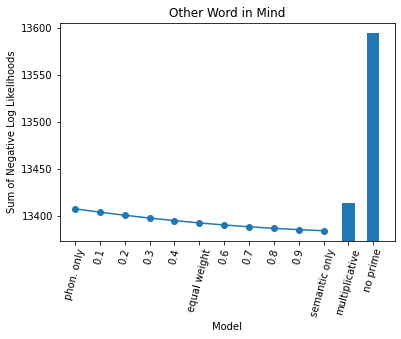

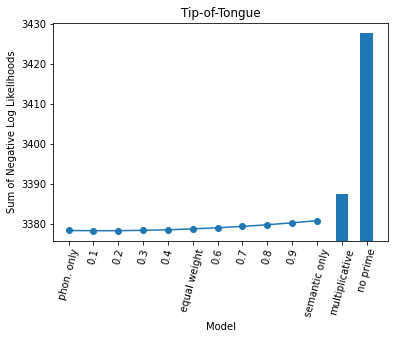

In [42]:
states = {"Know the Answer": knowg, "Don't Know the Answer": dontknowg, "Other Word in Mind": otherwordg, "Tip-of-Tongue": totg}
for state in states.keys():
  y = -1*states[state]['rLL']
  k = (max(y) - min(y)) / 20
  plt.plot(x[:11],y[:1.0],marker="o")
  plt.bar(x[11:],y[1.1:], width=.05)
  plt.ylim(min(y)-k, max(y)+k)
  plt.xlabel("Model")
  plt.ylabel("Sum of Negative Log Likelihoods")
  plt.title(state)
  plt.xticks(x,values, rotation=75)
  plt.show()

# No-Response

In [ ]:
noresp = julie_files[julie_files['Resp'] == '12345']
len(noresp)

7537

In [ ]:
bycond = noresp.groupby('PrimeCondition')

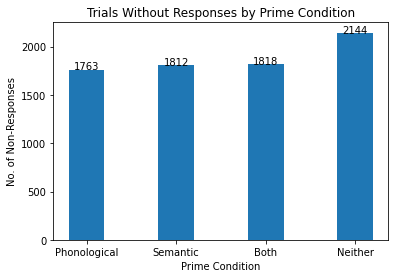

In [ ]:
conds = ['Phonological', 'Semantic', 'Both', 'Neither']
counts = [len(bycond.get_group(x)) for x in ['P', 'R', 'B', 'U']]
plt.bar(conds, counts, width = 0.4)
for i in range(len(conds)):
  plt.text(i, counts[i], counts[i], ha = 'center') 
plt.xlabel("Prime Condition")
plt.ylabel("No. of Non-Responses")
plt.title("Trials Without Responses by Prime Condition")
plt.show()

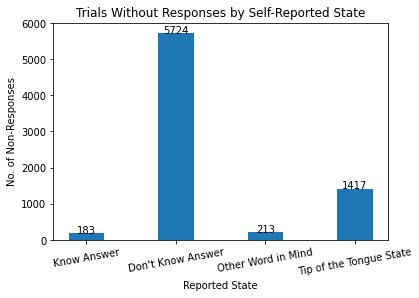

In [ ]:
st = ["Know Answer", "Don't Know Answer", "Other Word in Mind", "Tip of the Tongue State"]
y = [len(noresp[noresp["Question.RESP"] == x]) for x in range(1,5)]
plt.bar(st, y, width = 0.4)
plt.xticks(rotation = 10)
for i in range(len(st)):
  plt.text(i, y[i], y[i], ha = 'center') 
plt.xlabel("Reported State")
plt.ylabel("No. of Non-Responses")
plt.title("Trials Without Responses by Self-Reported State")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key w

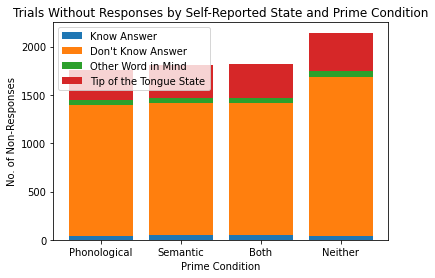

In [ ]:
ka = [len(noresp[(noresp['Question.RESP'] == 1)&(julie_files['PrimeCondition'] == p)]) for p in ['P', 'R', 'B', 'U']]
dka = [len(noresp[(noresp['Question.RESP'] == 2)&(julie_files['PrimeCondition'] == p)]) for p in ['P', 'R', 'B', 'U']]
owim = [len(noresp[(noresp['Question.RESP'] == 3)&(julie_files['PrimeCondition'] == p)]) for p in ['P', 'R', 'B', 'U']]
tots = [len(noresp[(noresp['Question.RESP'] == 4)&(julie_files['PrimeCondition'] == p)]) for p in ['P', 'R', 'B', 'U']]
width = 0.35       # the width of the bars: can also be len(x) sequence



plt.bar(conds, np.array(ka))
plt.bar(conds, dka, bottom = np.array(ka))
plt.bar(conds, owim, bottom = np.array(ka) + np.array(dka))
plt.bar(conds, tots, bottom = np.array(ka) + np.array(dka) + np.array(owim))

plt.xlabel("Prime Condition")
plt.ylabel("No. of Non-Responses")
plt.title('Trials Without Responses by Self-Reported State and Prime Condition')
plt.legend(["Know Answer", "Don't Know Answer", "Other Word in Mind", "Tip of the Tongue State"])

plt.show()


# Old stuff

Completed with n 1
Completed with n 2
Completed with n 3
Completed with n 4
Completed with n 5
Completed with n 6
Completed with n 7
Completed with n 8
Completed with n 9
Completed with n 10
Completed with n 11
Completed with n 12
Completed with n 13
Completed with n 14
Completed with n 15
Completed with n 16
Completed with n 17
Completed with n 18
Completed with n 19
Completed with n 20


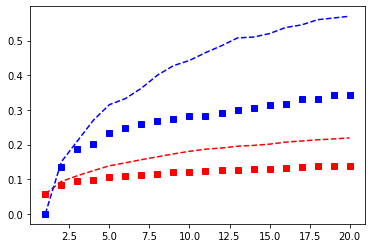

In [ ]:
# plot response and target accuracy together with varying n's, theta = .8
rAdd = []
rMult = []
tAdd = []
tMult = []
x = range(1,21)
for i in x:
  acc = accuracy_overall(vocab, i, 0.8)
  rAdd.append(acc[0])
  rMult.append(acc[1])
  tAdd.append(acc[2])
  tMult.append(acc[3])
  print("Completed with n", i)

plt.plot(x, rAdd, 'r--', x, rMult, 'rs', x, tAdd, 'b--', x, tMult, 'bs')

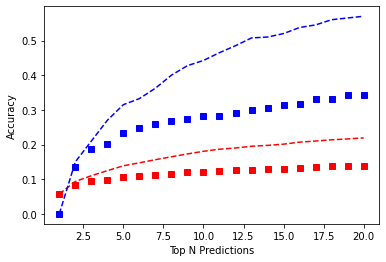

In [ ]:
plt.plot(x, rAdd, 'r--', x, rMult, 'rs', x, tAdd, 'b--', x, tMult, 'bs')
plt.xlabel("Top N Predictions")
plt.ylabel("Accuracy")
plt.show()

Accuracy of additive model: 0.07744531053557958
Accuracy of multiplicative model: 0.12195121951219512
Completed with alpha 0.0
Accuracy of additive model: 0.08901181795323108
Accuracy of multiplicative model: 0.12195121951219512
Completed with alpha 0.1
Accuracy of additive model: 0.09504651747548404
Accuracy of multiplicative model: 0.12195121951219512
Completed with alpha 0.2
Accuracy of additive model: 0.10611013326628112
Accuracy of multiplicative model: 0.12195121951219512
Completed with alpha 0.30000000000000004
Accuracy of additive model: 0.1249685692733216
Accuracy of multiplicative model: 0.12195121951219512
Completed with alpha 0.4
Accuracy of additive model: 0.14382700528036207
Accuracy of multiplicative model: 0.12195121951219512
Completed with alpha 0.5
Accuracy of additive model: 0.16117676640683934
Accuracy of multiplicative model: 0.12195121951219512
Completed with alpha 0.6000000000000001
Accuracy of additive model: 0.17374905707819965
Accuracy of multiplicative model:

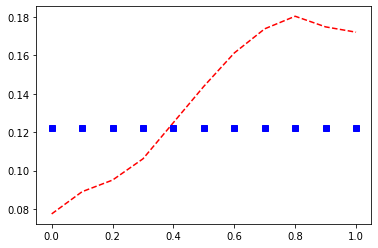

In [ ]:
# plot accuracy as a function of n or theta for both add and mult 
#nvals = [i for i in range(5, 11)] #change upper bound depending on value of topn used in generate_predictions()
#plt.plot(nvals, accuracy_overall(vocab, nvals)[0], 'r--', nvals, accuracy_overall(vocab, nvals)[1]) 
a = [x * 0.1 for x in range(11)]
yAdd = []
yMult = []
for i in a:
  acc = accuracy_overall(vocab, 10, i, resp_wide)
  yAdd.append(acc[0])
  yMult.append(acc[1])
  print("Completed with theta", i)

plt.plot(a, yAdd, 'r--', a, yMult, 'bs')
plt.show()

# Measure target accuracy


In [ ]:
targetacc_data

,ActualPrime,PrimeCondition,Target,prompt
0,absolve,P,abstain,To refrain deliberately and often with an effo...
1,Norderstedt,B,Nuremberg,German city for which antisemitic laws were named
2,hematoma,B,hemorrhage,"The escape of blood from vessels, including in..."
3,thigh,U,Seoul,Capital of South Korea
4,Oslo,R,Helsinki,Capital of Finland
...,...,...,...,...
395,terse,B,taciturn,"Saying little, reserved, uncommunicative"
396,bagel,U,chameleon,A small lizard with skin that changes color to...
397,Sardinia,B,Sicily,The largest Mediterranean island; the Italian ...
398,Shelley,B,Shaw,Last name of Irish author well known for Pygma...


In [ ]:
saved_prompt_acts = prompt_acts
saved_prime_acts = prime_acts

In [ ]:
# modify functions for targetacc_data
targ_add_success = []
targ_mult_success = []
def targ_acc_single(t, vocab_words, n, theta, data):
  prompt_neighbors = saved_prompt_acts[data["prompt"][t]]
  if data["ActualPrime"][t] not in saved_prime_acts:
    a, b = activate_prime_neighbors(prompt_neighbors, data["ActualPrime"][t])
    saved_prime_acts[data["ActualPrime"][t]] = (a, b)
  else:
    a, b = saved_prime_acts[data["ActualPrime"][t]]
  final_add = combine_semantic_phonological(a, b, "add", theta)
  final_mult = combine_semantic_phonological(a, b, "multiply")
  preds_add = generate_predictions(final_add, vocab_words, topn = 10)
  preds_mult = generate_predictions(final_mult, vocab_words, topn = 10)
  if data["Target"][t] in preds_add[:n]:
    targ_add_success.append(1)
  else:
    targ_add_success.append(0)
  if data["Target"][t] in preds_mult[:n]:
    targ_mult_success.append(1)
  else:
    targ_mult_success.append(0)

def targ_acc_overall(vocab_words, n, theta, data):
  # returns the overall probability that the target will appear in the top n words predicted by the model
  targ_add_success.clear()
  targ_mult_success.clear()
  for t in range(len(data.index)):
    targ_acc_single(t, vocab_words, n, theta, data)
  acc_add = np.mean(targ_add_success)
  acc_mult = np.mean(targ_mult_success)
  print("Accuracy of additive model:", acc_add)
  print("Accuracy of multiplicative model:", acc_mult)
  return acc_add, acc_mult

Accuracy of additive model: 0.0825
Accuracy of multiplicative model: 0.2825
Completed with alpha 0.0
Accuracy of additive model: 0.1375
Accuracy of multiplicative model: 0.2825
Completed with alpha 0.1
Accuracy of additive model: 0.1725
Accuracy of multiplicative model: 0.2825
Completed with alpha 0.2
Accuracy of additive model: 0.23
Accuracy of multiplicative model: 0.2825
Completed with alpha 0.30000000000000004
Accuracy of additive model: 0.2925
Accuracy of multiplicative model: 0.2825
Completed with alpha 0.4
Accuracy of additive model: 0.355
Accuracy of multiplicative model: 0.2825
Completed with alpha 0.5
Accuracy of additive model: 0.4075
Accuracy of multiplicative model: 0.2825
Completed with alpha 0.6000000000000001
Accuracy of additive model: 0.44
Accuracy of multiplicative model: 0.2825
Completed with alpha 0.7000000000000001
Accuracy of additive model: 0.4425
Accuracy of multiplicative model: 0.2825
Completed with alpha 0.8
Accuracy of additive model: 0.41
Accuracy of multi

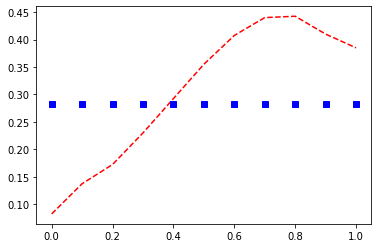

In [ ]:
targAdd = []
targMult = []
for i in a:
  acc = targ_acc_overall(vocab, 10, i, targetacc_data)
  targAdd.append(acc[0])
  targMult.append(acc[1])
  print("Completed with theta", i)

plt.plot(a, targAdd, 'r--', a, targMult, 'bs')
plt.show()

More plots

NameError: ignored

# model predictions: examples

In [ ]:
add, mult = lexical_retrieval_model("Capital of Finland", "Helsinki", vocab)
print("predictions for additive model:", add)
print("predictions for multiplicative model:", mult)

predictions for additive model: ['Helsinki', 'Finland', 'Czechoslovakia', 'Oslo', 'Nordic', 'Sweden', 'Berlin', 'Holland', 'Iceland', 'Celtic']
predictions for multiplicative model: ['Holland', 'Czechoslovakia', 'Berlin', 'Celtic', 'Helsinki', 'ski', 'Alpine', 'herring', 'Pilsen', 'clingy']


In [ ]:
add, mult = lexical_retrieval_model("A mathematical expression consisting of two terms", "bilateral", vocab)
print("predictions for additive model:", add)
print("predictions for multiplicative model:", mult)

predictions for additive model: ['biannual', 'bilateral', 'integral', 'mathematical', 'bisexual', 'partial', 'paternal', 'interval', 'binomial', 'mutual']
predictions for multiplicative model: ['bilateral', 'biannual', 'integral', 'binomial', 'paternal', 'interval', 'bisexual', 'partial', 'plural', 'mathematical']


In [ ]:
add, mult = lexical_retrieval_model("Identical in form; coinciding exactly when superimposed", "cognizant", vocab)
print("predictions for additive model:", add)
print("predictions for multiplicative model:", mult)

predictions for additive model: ['constant', 'cognition', 'cognizant', 'cognitive', 'confidant', 'confident', 'congruent', 'ignorant', 'coinciding', 'recognition']
predictions for multiplicative model: ['cognition', 'cognizant', 'cognitive', 'confident', 'confidant', 'constant', 'recognition', 'ignorant', 'coinciding', 'congruent']
